In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# -------------------------
# 1. Basic Invertible Layers
# -------------------------

class ActNorm(keras.layers.Layer):
    """
    Activation Normalization.
    This layer learns per-channel bias and scale.
    It initializes its parameters from the first batch.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.initialized = False

    def build(self, input_shape):
        # Assume input shape: (batch_size, d)
        d = input_shape[-1]
        self.bias = self.add_weight(shape=(d,),
                                    initializer="zeros",
                                    trainable=True,
                                    name="bias")
        self.log_scale = self.add_weight(shape=(d,),
                                         initializer="zeros",
                                         trainable=True,
                                         name="log_scale")
        super().build(input_shape)

    def call(self, inputs, training=False):
        if (not self.initialized) and training:
            # Initialize parameters based on first batch statistics.
            mean = tf.reduce_mean(inputs, axis=0)
            std = tf.math.reduce_std(inputs, axis=0) + 1e-6
            self.bias.assign(-mean)
            self.log_scale.assign(tf.math.log(1.0 / std))
            self.initialized = True
        return (inputs + self.bias) * tf.exp(self.log_scale)

class Invertible1x1Conv(keras.layers.Layer):
    """
    Invertible 1x1 Convolution.
    For a vector input, this is just a learned linear (square) transform.
    """
    def __init__(self, channels, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels

    def build(self, input_shape):
        # Initialize with a random orthogonal matrix
        w_init = np.linalg.qr(np.random.randn(self.channels, self.channels))[0].astype(np.float32)
        self.W = self.add_weight(shape=(self.channels, self.channels),
                                 initializer=tf.constant_initializer(w_init),
                                 trainable=True,
                                 name="W")
        super().build(input_shape)

    def call(self, inputs, training=False):
        return tf.linalg.matmul(inputs, self.W)

    def inverse(self, inputs):
        W_inv = tf.linalg.inv(self.W)
        return tf.linalg.matmul(inputs, W_inv)

# -------------------------
# 2. Conditional Coupling Layer
# -------------------------

class ConditionalAffineCoupling(keras.layers.Layer):
    """
    Conditional Affine Coupling Layer.
    Splits y into two parts. The transformation on one part (y2) is
    computed by a NN that takes the other part (y1) and the condition x.
    """
    def __init__(self, hidden_units=128, condition_dim=10, **kwargs):
        super().__init__(**kwargs)
        self.hidden_units = hidden_units
        self.condition_dim = condition_dim

    def build(self, input_shape):
        # input_shape is the shape of y (batch_size, d)
        d = input_shape[-1]
        # We split y into two parts.
        # Let d1 be the size of the first part and d2 for the second.
        self.d1 = d // 2
        self.d2 = d - self.d1

        # The NN will take [y1, x] as input and output shift and log-scale for y2.
        self.nn = keras.Sequential([
            keras.layers.Dense(self.hidden_units, activation="relu"),
            keras.layers.Dense(self.hidden_units, activation="relu"),
            keras.layers.Dense(2 * self.d2, activation="linear")
        ], name="coupling_nn")
        super().build(input_shape)

    def call(self, y, condition, training=False):
        # Split y into two parts: y1 and y2.
        y1 = y[:, :self.d1]
        y2 = y[:, self.d1:]
        # Concatenate y1 with the conditioning vector x.
        nn_input = tf.concat([y1, condition], axis=-1)
        params = self.nn(nn_input)
        shift, log_scale = tf.split(params, num_or_size_splits=2, axis=-1)
        # Apply the affine transformation to y2.
        y2_trans = y2 * tf.exp(log_scale) + shift
        # Compute log-determinant of the Jacobian (only depends on the scaling).
        log_det = tf.reduce_sum(log_scale, axis=-1)
        # Concatenate y1 (unchanged) and transformed y2.
        y_out = tf.concat([y1, y2_trans], axis=-1)
        return y_out, log_det

    def inverse(self, y, condition):
        y1 = y[:, :self.d1]
        y2 = y[:, self.d1:]
        nn_input = tf.concat([y1, condition], axis=-1)
        params = self.nn(nn_input)
        shift, log_scale = tf.split(params, num_or_size_splits=2, axis=-1)
        # Inverse transformation for y2.
        y2_inv = (y2 - shift) / tf.exp(log_scale)
        y_inv = tf.concat([y1, y2_inv], axis=-1)
        return y_inv

# -------------------------
# 3. One Conditional Glow Block
# -------------------------

class ConditionalGlowBlock(keras.layers.Layer):
    """
    One Glow Block that includes:
      ActNorm -> Invertible 1x1 Conv -> Conditional Affine Coupling
    It processes the target y (of shape (batch, 8)) conditioned on x (of shape (batch,10)).
    """
    def __init__(self, channels, condition_dim, **kwargs):
        super().__init__(**kwargs)
        self.act_norm = ActNorm(name="act_norm")
        self.inv_conv = Invertible1x1Conv(channels, name="inv_conv")
        self.coupling = ConditionalAffineCoupling(condition_dim=condition_dim, name="cond_coupling")

    def call(self, y, condition, training=False):
        # Apply ActNorm.
        y = self.act_norm(y, training=training)
        # Apply invertible 1x1 convolution.
        y = self.inv_conv(y, training=training)
        # Apply the conditional affine coupling.
        y, log_det = self.coupling(y, condition, training=training)
        return y, log_det

    def inverse(self, y, condition):
        # Inverse order: first invert coupling, then conv, then ActNorm.
        y = self.coupling.inverse(y, condition)
        y = self.inv_conv.inverse(y)
        y = self.act_norm(y)  # ActNorm is typically data dependent only at training init.
        return y

# -------------------------
# 4. Conditional Glow Model
# -------------------------

class ConditionalGlowModel(keras.Model):
    """
    The conditional Glow model maps targets y to latent variables z
    conditioned on x. In training we maximize the log-likelihood
    (or equivalently, minimize negative log-likelihood).
    
    Input shapes:
      - y: (batch, 8)   (target to be modeled)
      - x: (batch, 10)  (conditioning input)
    """
    def __init__(self, num_blocks=3, y_dim=8, condition_dim=10, **kwargs):
        super().__init__(**kwargs)
        self.y_dim = y_dim
        self.condition_dim = condition_dim
        self.blocks = [ConditionalGlowBlock(channels=y_dim, condition_dim=condition_dim, name=f"glow_block_{i}") 
                       for i in range(num_blocks)]
        # Learnable parameters for the base Gaussian distribution (for z ~ N(prior_mu, diag(exp(prior_logvar)))).
        self.prior_mu = tf.Variable(tf.zeros([y_dim]), trainable=True, name="prior_mu")
        self.prior_logvar = tf.Variable(tf.zeros([y_dim]), trainable=True, name="prior_logvar")

    def call(self, y, condition, training=False):
        log_det_total = 0.0
        z = y
        # Pass through each Glow block.
        for block in self.blocks:
            z, log_det = block(z, condition, training=training)
            log_det_total += log_det
        return z, log_det_total

    def inverse(self, z, condition):
        y = z
        # Invert the flow (apply blocks in reverse order).
        for block in reversed(self.blocks):
            y = block.inverse(y, condition)
        return y

    def log_prob(self, y, condition):
        """
        Compute the log-likelihood of y given condition x.
        Uses the change-of-variables formula:
          log p(y|x) = log p(z) + log|det(dz/dy)|
        where z = f(y; x).
        """
        z, log_det_total = self.call(y, condition, training=False)
        # Log-probability under the base Gaussian.
        log_prob_z = -0.5 * tf.reduce_sum(
            (z - self.prior_mu) ** 2 / tf.exp(self.prior_logvar) + self.prior_logvar + tf.math.log(2 * np.pi),
            axis=-1
        )
        return log_prob_z + log_det_total

    def loss_fn(self, y, condition):
        """
        Loss function: negative log-likelihood (to be minimized).
        """
        logp = self.log_prob(y, condition)
        return -tf.reduce_mean(logp)

# -------------------------
# 5. Training Loop Example
# -------------------------

# Create an instance of the conditional Glow model.
# Here, y_dim=8 (target dimension) and condition_dim=10 (input dimension).
model = ConditionalGlowModel(num_blocks=3, y_dim=8, condition_dim=10)

# Choose an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# Dummy training data for demonstration.
# x_train has shape (N,10) and y_train has shape (N,8).
N = 1000
x_train = np.random.randn(N, 10).astype(np.float32)
y_train = np.random.randn(N, 8).astype(np.float32)

# Create a tf.data.Dataset.
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((y_train, x_train)).shuffle(1000).batch(batch_size)

# Training loop.
epochs = 5
for epoch in range(epochs):
    for step, (y_batch, x_batch) in enumerate(dataset):
        with tf.GradientTape() as tape:
            loss = model.loss_fn(y_batch, x_batch)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        if step % 50 == 0:
            print(f"Epoch {epoch+1} Step {step} Loss: {loss.numpy():.4f}")

# -------------------------
# 6. Inference (Regression Prediction)
# -------------------------
# For regression we can “invert” the flow.
# One common strategy is to use the mode of the base distribution (e.g., z = prior_mu, often zero)
# and then compute:
#      y_pred = f^{-1}(z, condition)
# Here we simply set z = prior_mu (or zero if you initialize prior_mu as zero).

# Example: Predict y for new condition data.
x_new = np.random.randn(5, 10).astype(np.float32)  # 5 new inputs
# Use the current prior mean as z (or set to zero vector).
z_sample = tf.broadcast_to(model.prior_mu, [5, model.y_dim])
y_pred = model.inverse(z_sample, x_new)
print("Predicted y (shape {}):\n{}".format(y_pred.shape, y_pred.numpy()))


2025-02-17 08:02:43.155887: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 08:02:43.285036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 08:02:45.315220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14275 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1 Step 0 Loss: 12.6240


2025-02-17 08:02:46.798316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 Step 0 Loss: 10.5860


2025-02-17 08:02:47.387670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 Step 0 Loss: 9.0217


2025-02-17 08:02:47.971419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 Step 0 Loss: 7.6985


2025-02-17 08:02:48.555737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5 Step 0 Loss: 6.5021
Predicted y (shape (5, 8)):
[[ 0.14844349  0.13013372 -0.11251299 -0.11529035 -0.08312796 -0.02169371
   0.16969731 -0.02461107]
 [-0.01370577  0.16216098 -0.14280328 -0.19830199  0.03553936 -0.17544271
  -0.01207663  0.16116694]
 [ 0.05467678  0.05204211  0.07636174 -0.05075334 -0.05314752  0.06761965
   0.16997842 -0.11502981]
 [-0.02142167  0.18208495  0.05364254 -0.14322342 -0.14888097 -0.14085631
  -0.24459513  0.03028866]
 [-0.09663666  0.12820198 -0.1608789   0.0947891  -0.01818602 -0.05152591
   0.1258589  -0.03356673]]


2025-02-17 08:02:49.137881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-17 08:02:49.141590: I tensorflow/core/util/cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x5ecba9cd8560


In [1]:
%reset -sf

import tensorflow as tf
import tf_keras
print("Tensorflow:", tf.__version__)
import tensorflow_probability as tfp
print("Tensorflow Probability:", tfp.__version__)

# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        
        # Instead of enabling memory growth, set a memory limit
        # memory_limit = 16_376 / 2 # Set the memory limit in MB
        memory_limit = -1
        if memory_limit >= 0:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2025-02-14 04:29:03.750384: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-14 04:29:03.771797: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.16.1
Tensorflow Probability: 0.24.0
1 Physical GPUs, 1 Logical GPU


2025-02-14 04:29:05.401640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14275 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [2]:
import sys
import os
import glob

HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH + "/qe")

import atlas_plot as ap

plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
WORKERS = 16

from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [3]:
import full_data as data

# reco
lead_lep = data.Lead_lep()
sublead_lep = data.Sublead_lep()
met = data.Met()

# truth
truth_lead_lep = data.Truth_lead_lep()
truth_sublead_lep = data.Truth_sublead_lep()
Truth_dilep = data.Truth_dilep()
truth_met = data.Truth_met()

# target Ws
w_lead = data.Lead_w()
w_sublead = data.Sublead_w()
mc_weight = data.MC_weight()

['/CGLMP', '/RecoLep0', '/RecoLep1', '/RecoMET', '/TruthCandLep0', '/TruthCandLep1', '/TruthCandMET', '/TruthHiggs', '/TruthLep0', '/TruthLep1', '/TruthLepN', '/TruthLepP', '/TruthNu0', '/TruthNu1', '/TruthNuN', '/TruthNuP', '/TruthW0', '/TruthW1', '/TruthWN', '/TruthWP', '/eventWeight', '/mcWeight', '/recoWeight', '/weight']


In [4]:
# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > 22
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > 15
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > 10
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > 20
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

# # define preselection cuts

# cut_pre_pt_lead = lead_lep.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
# cut_pre_pt_sub = sublead_lep.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
# cut_pre_dilep_m = (
#     np.sqrt(
#         np.square(lead_lep.energy + sublead_lep.energy)
#         - np.square(lead_lep.px + sublead_lep.px)
#         - np.square(lead_lep.py + sublead_lep.py)
#         - np.square(lead_lep.pz + sublead_lep.pz)
#     )
#     > -9999
# )
# print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
# cut_pre_pt_miss = met.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
# PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
# print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
# del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)


0
29961
44269
89634
157782


In [5]:
# truth
truth_lead_lep_px = pd.DataFrame(truth_lead_lep.px[PRE_CUT])
truth_lead_lep_py = pd.DataFrame(truth_lead_lep.py[PRE_CUT])
truth_lead_lep_pz = pd.DataFrame(truth_lead_lep.pz[PRE_CUT])
truth_lead_lep_energy = pd.DataFrame(truth_lead_lep.energy[PRE_CUT])
truth_lead_lep_p4 = pd.concat(
	[truth_lead_lep_px, truth_lead_lep_py, truth_lead_lep_pz, truth_lead_lep_energy],
	axis=1,
).to_numpy()
truth_sublead_lep_px = pd.DataFrame(truth_sublead_lep.px[PRE_CUT])
truth_sublead_lep_py = pd.DataFrame(truth_sublead_lep.py[PRE_CUT])
truth_sublead_lep_pz = pd.DataFrame(truth_sublead_lep.pz[PRE_CUT])
truth_sublead_lep_energy = pd.DataFrame(truth_sublead_lep.energy[PRE_CUT])
truth_sublead_lep_p4 = pd.concat(
	[truth_sublead_lep_px, truth_sublead_lep_py, truth_sublead_lep_pz, truth_sublead_lep_energy],
	axis=1,
).to_numpy()
# reco
lead_lep_px = pd.DataFrame(lead_lep.px[PRE_CUT])
lead_lep_py = pd.DataFrame(lead_lep.py[PRE_CUT])
lead_lep_pz = pd.DataFrame(lead_lep.pz[PRE_CUT])
lead_lep_energy = pd.DataFrame(lead_lep.energy[PRE_CUT])
lead_lep_p4 = pd.concat(
	[lead_lep_px, lead_lep_py, lead_lep_pz, lead_lep_energy],
	axis=1,
).to_numpy()
sublead_lep_px = pd.DataFrame(sublead_lep.px[PRE_CUT])
sublead_lep_py = pd.DataFrame(sublead_lep.py[PRE_CUT])
sublead_lep_pz = pd.DataFrame(sublead_lep.pz[PRE_CUT])
sublead_lep_energy = pd.DataFrame(sublead_lep.energy[PRE_CUT])
sublead_lep_p4 = pd.concat(
	[sublead_lep_px, sublead_lep_py, sublead_lep_pz, sublead_lep_energy],
	axis=1,
).to_numpy()

In [6]:

## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep.px,
        lead_lep.py,
        lead_lep.pz,
        lead_lep.energy,
        sublead_lep.px,
        sublead_lep.py,
        sublead_lep.pz,
        sublead_lep.energy,
        # np.log(sublead_lep.energy),
        # np.log(lead_lep.energy),
        # lead_lep.eta,
        # sublead_lep.eta,
        met.px,
        met.py,
    )
)[PRE_CUT]

# weights
mc_weight = mc_weight.w.to_numpy()[PRE_CUT]

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array

# ROBUST_OBS = RobustScaler()
# obs_kin = ROBUST_OBS.fit_transform(obs_kin)
# print(type(obs_kin))

int_kin shape: (851115, 10)


In [7]:
## Interesting variables

w_lead_px = pd.DataFrame(w_lead.px[PRE_CUT])
w_lead_py = pd.DataFrame(w_lead.py[PRE_CUT])
w_lead_pz = pd.DataFrame(w_lead.pz[PRE_CUT])
w_lead_e = pd.DataFrame(w_lead.energy[PRE_CUT])
w_lead_log_e = pd.DataFrame(np.log(w_lead_e))
w_lead_sqrt_e = pd.DataFrame(np.sqrt(w_lead_e))
w_sublead_px = pd.DataFrame(w_sublead.px[PRE_CUT])
w_sublead_py = pd.DataFrame(w_sublead.py[PRE_CUT])
w_sublead_pz = pd.DataFrame(w_sublead.pz[PRE_CUT])
w_sublead_e = pd.DataFrame(w_sublead.energy[PRE_CUT])
w_sublead_log_e = pd.DataFrame(np.log(w_sublead_e))
w_sublead_sqrt_e = pd.DataFrame(np.sqrt(w_sublead_e))
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])

# Kinematics of interesting variables (target for training)
int_kin = np.concatenate(
    [
        w_lead_px,
        w_lead_py,
        w_lead_pz,
        w_lead_e,
        w_sublead_px,
        w_sublead_py,
        w_sublead_pz,
        w_sublead_e,
        # np.square(w_lead_m) / np.mean(w_lead_m),
        # np.square(w_sublead_m) / np.mean(w_lead_m),
        # w_lead_m,
        # w_sublead_m,
    ],
    axis=-1,
)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (851115, 8)
<class 'numpy.ndarray'>


In [8]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
# test_x = np.concatenate([test_x, valid_x], axis=0)

train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]
# test_y = np.concatenate([test_y, valid_y], axis=0)

print("Total evts:", len(indices_arr))
print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

Total evts: 851115
X (Interest)
Training data shape: (680892, 10);
Validing data shape: (85111, 10);
Testing data shape: (85112, 10).
Y (Observed)
Training data shape: (680892, 8);
Validing data shape: (85111, 8);
Testing data shape: (85112, 8).


In [9]:
# training variables
BATCH_SIZE = 512
EPOCHS = 1024
LEARNING_RATE = 1e-5

# create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_x, tf.float32), 
    tf.cast(train_y, tf.float32)
)).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(valid_x, tf.float32), 
    tf.cast(valid_y, tf.float32)
)).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create and compile model
input_dim = train_x.shape[-1]  # 2 W bosons × 4-vectors
model = CustomRealNVP(input_dim=input_dim, n_coupling_layers=6)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    mse_weight=9.8,
    mass_weight=2.0,
    higgs_mass_weight=1.0,
    dinu_pt_weight=0.9,
    flow_weight=0.1,
    jit_compile=True,
    steps_per_execution=256,
)

# Train model
model.summary()
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    batch_size=128,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
)

# Generate new samples
z = tf.random.normal(shape=(1000, input_dim))
generated_samples = model(z, inverse=True)

Model: "custom_real_nvp_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1024


ValueError: Exception encountered when calling layer 'coupling_layer_2' (type CouplingLayer).

Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 8), found shape=(8, 10)

Call arguments received by layer 'coupling_layer_2' (type CouplingLayer):
  • x=tf.Tensor(shape=(None, 10), dtype=float32)
  • inverse=False

In [ ]:
# Make a directory
dir_name = HOME_PATH + "/10th_trial/ww_resregressor_result/"
savedmodel_path = dir_name + "saved_model"
name = "ww_resregressor"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save modela
model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)
tf.saved_model.save(model, savedmodel_path) # save model in saved_model format --> use in the onnx 

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

Directory /root/work/QE-mls/10th_trial/ww_resregressor_result/ cleaned.
Directory /root/work/QE-mls/10th_trial/ww_resregressor_result/ exists.


/root/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


INFO:tensorflow:Assets written to: /root/work/QE-mls/10th_trial/ww_resregressor_result/saved_model/assets


INFO:tensorflow:Assets written to: /root/work/QE-mls/10th_trial/ww_resregressor_result/saved_model/assets


2660/2660 ━━━━━━━━━━━━━━━━━━━━ 6s 991us/step


I0000 00:00:1739445528.941822  790205 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1739445529.150371  790187 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1739445529.197760  790206 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 212 bytes spill stores, 212 bytes spill loads

I0000 00:00:1739445529.229849  790192 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 12 bytes spill stores, 12 bytes spill loads

2025-02-13 11:18:50.202078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1739445532.008079  790387 asm_compiler.cc:369] ptxas warning : Register

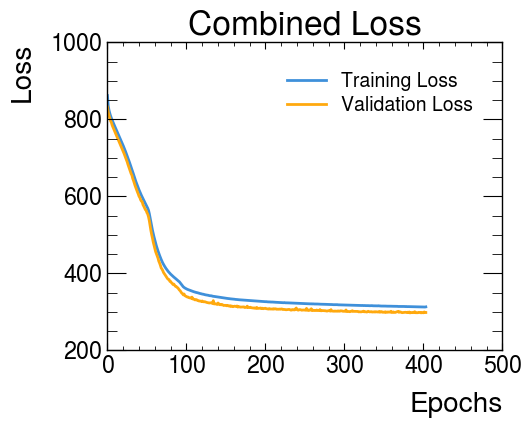

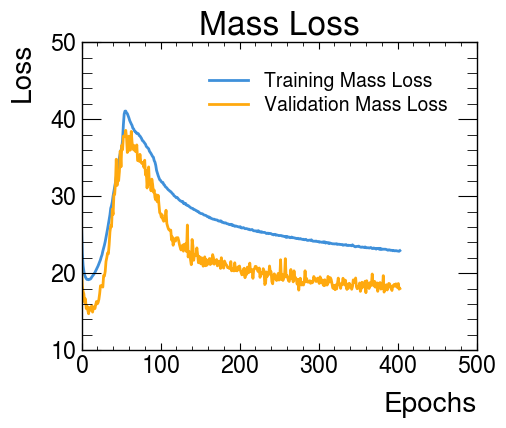

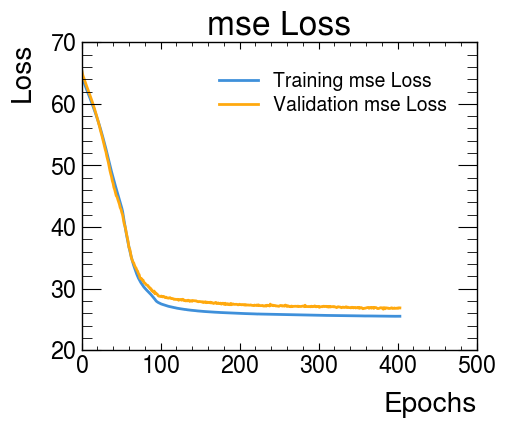

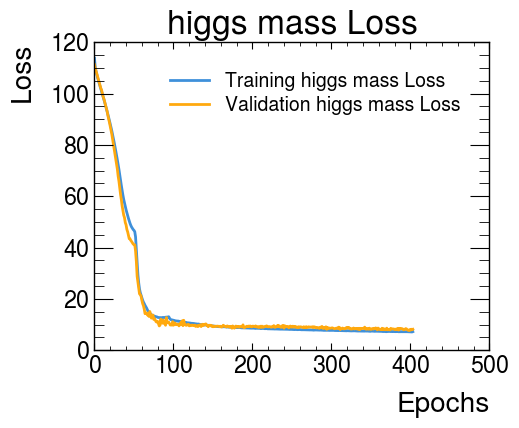

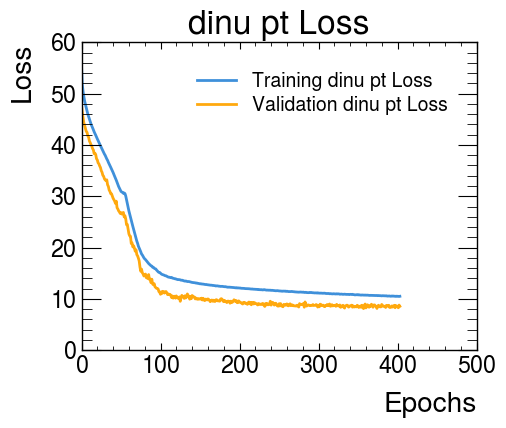

In [ ]:
# Extract loss values
loss = history.history["loss"]
val_loss = history.history["val_loss"]
mass_loss = history.history["mass_loss"]
val_mass_loss = history.history["val_mass_loss"]
mse_loss = history.history["mse_loss"]
val_mse_loss = history.history["val_mse_loss"]
higgs_mass_loss = history.history["higgs_mass_loss"]
val_higgs_mass_loss = history.history["val_higgs_mass_loss"]
dinu_pt_loss = history.history["dinu_pt_loss"]
val_dinu_pt_loss = history.history["val_dinu_pt_loss"]


# 1) Plot combined training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined Loss")
plt.legend()
plt.grid(False)
plt.show()

# 2) Plot mass training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(mass_loss, label="Training Mass Loss")
plt.plot(val_mass_loss, label="Validation Mass Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Mass Loss")
plt.legend()
plt.grid(False)
plt.show()

# 3) Plot mse training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(mse_loss, label="Training mse Loss")
plt.plot(val_mse_loss, label="Validation mse Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("mse Loss")
plt.legend()
plt.grid(False)
plt.show()

# 4) Plot higgs mass training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(higgs_mass_loss, label="Training higgs mass Loss")
plt.plot(val_higgs_mass_loss, label="Validation higgs mass Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("higgs mass Loss")
plt.legend()
plt.grid(False)
plt.show()

# 5) Plot dinu pt loss
plt.figure(figsize=(5, 4))
plt.plot(dinu_pt_loss, label="Training dinu pt Loss")
plt.plot(val_dinu_pt_loss, label="Validation dinu pt Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("dinu pt Loss")
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz",
    pred_y=sig_pred.reshape(sig_truth.shape),
    test_y=sig_truth,
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00, 7.0000e+00,
        1.1000e+01, 3.8000e+01, 2.9700e+02, 8.1994e+04, 2.6800e+03,
        6.4000e+01, 6.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-48312.37781705, -47205.17608703, -46097.97435701, -44990.77262699,
        -43883.57089697, -42776.36916695, -41669.16743693, -40561.96570691,
        -39454.76397688, -38347.56224686, -37240.36051684, -36133.15878682,
        -35025.9570568 , -33918.75532678, -32811.55359676, -31704.35186674,
        -30597

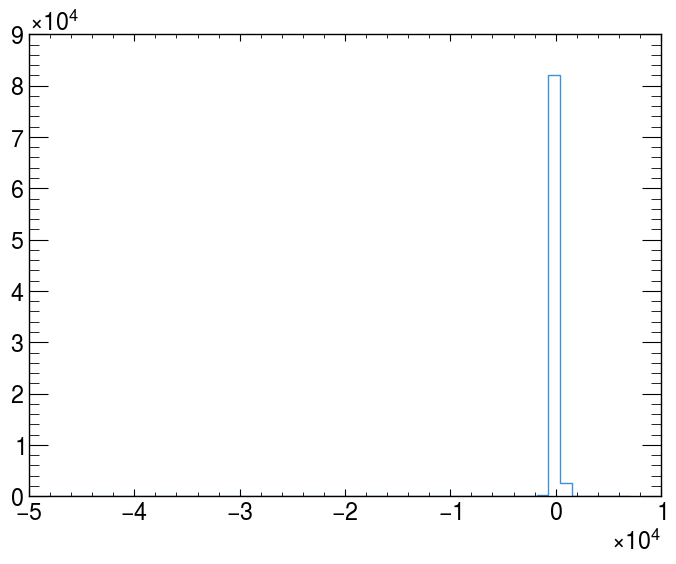

In [ ]:
# neutrino mass checking
nu0_4vect = sig_pred_inv[:, :4] - test_x[:, :4]
nu1_4vect = sig_pred_inv[:, 4:8] - test_x[:, 4:8]
nu0_mass_squared = np.square(nu0_4vect[:, 3]) - np.square(nu0_4vect[:, 0]) - np.square(nu0_4vect[:, 1]) - np.square(nu0_4vect[:, 2])
nu1_mass_squared = np.square(nu1_4vect[:, 3]) - np.square(nu1_4vect[:, 0]) - np.square(nu1_4vect[:, 1]) - np.square(nu1_4vect[:, 2])
# nu0_mass_squared
plt.hist(nu0_mass_squared, bins=50, histtype="step", label="nu0_mass_squared")
# plt.hist(nu1_mass_squared, bins=100, range=(0, 100), histtype="step", label="nu1_mass_squared")


Truth mean: 0.031, std: 39.544, min: -585.857, max: 803.254


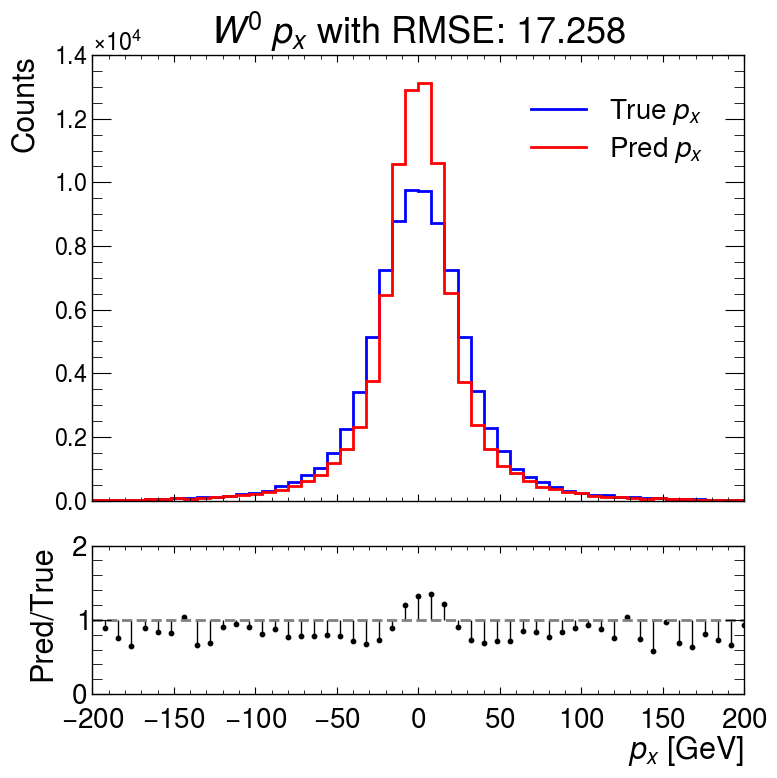

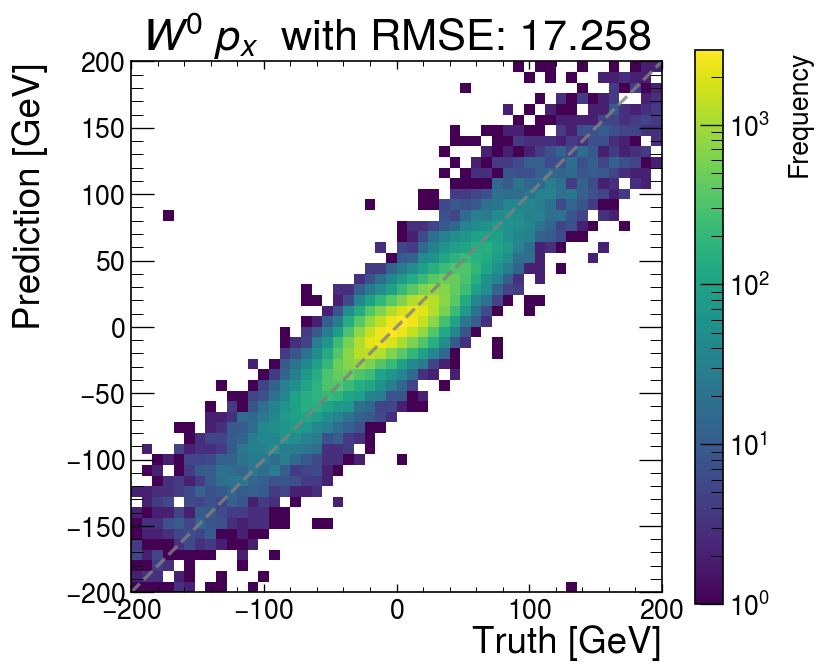

In [ ]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$p_{x}$",
    title="$W^{0}$ $p_{x}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"$W^{0}$ $p_{x}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50,
)

Truth mean: -0.124, std: 27.801, min: -399.814, max: 373.865


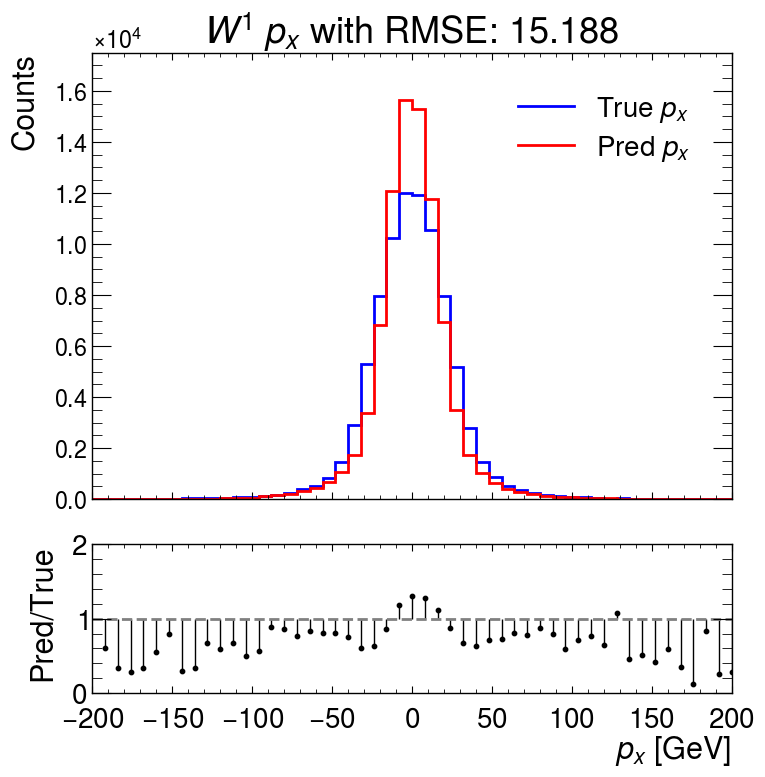

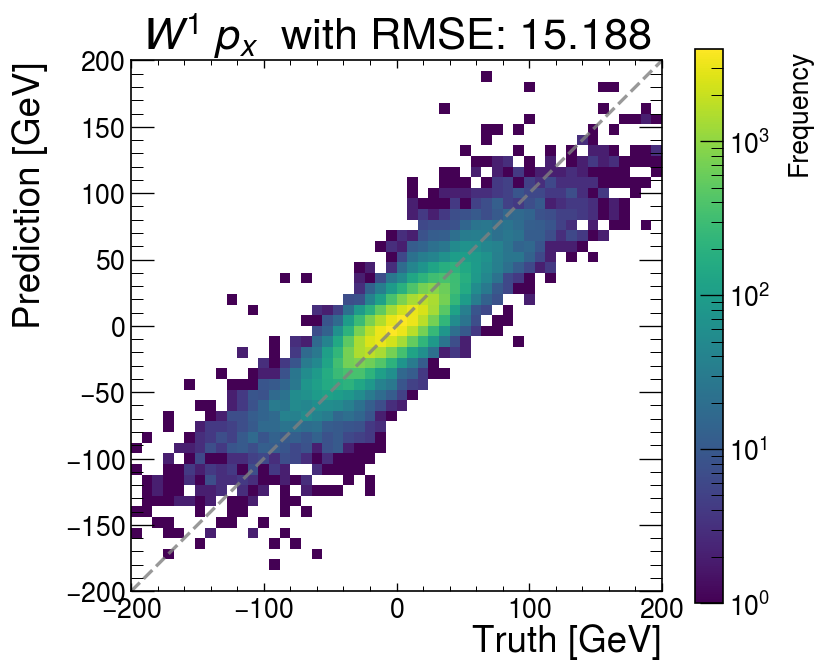

In [ ]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,4]):.3f}, std: {np.std(sig_truth_inv[:,4]):.3f}, min: {np.min(sig_truth_inv[:,4]):.3f}, max: {np.max(sig_truth_inv[:,4]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 4], sig_pred_inv[:, 4]],
    label=r"$p_{x}$",
    title="$W^{1}$ $p_{x}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 4],
    sig_pred_inv[:, 4],
    r"$W^{1}$ $p_{x}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50 
)

Truth mean: -0.013, std: 39.620, min: -755.579, max: 609.143


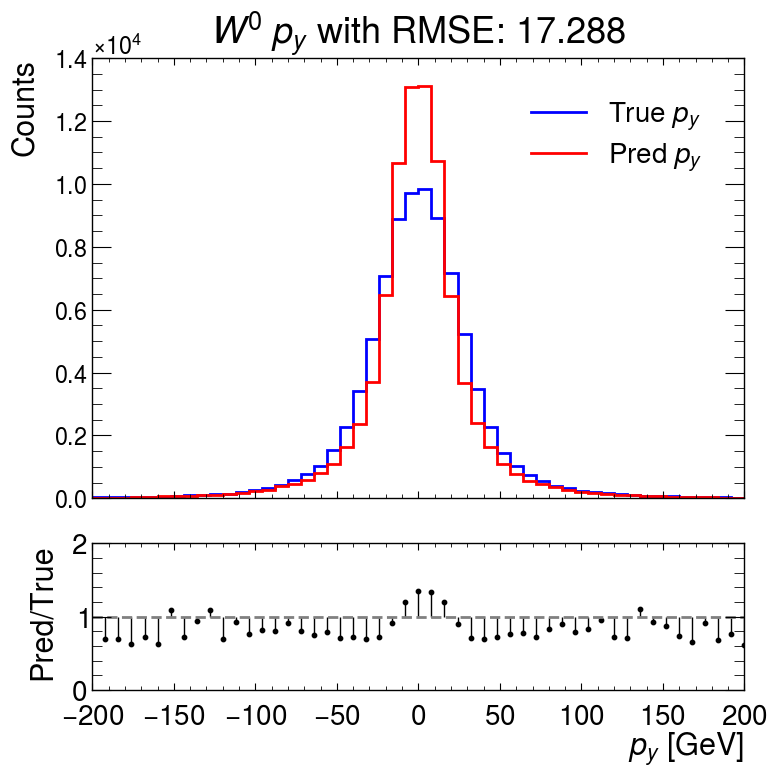

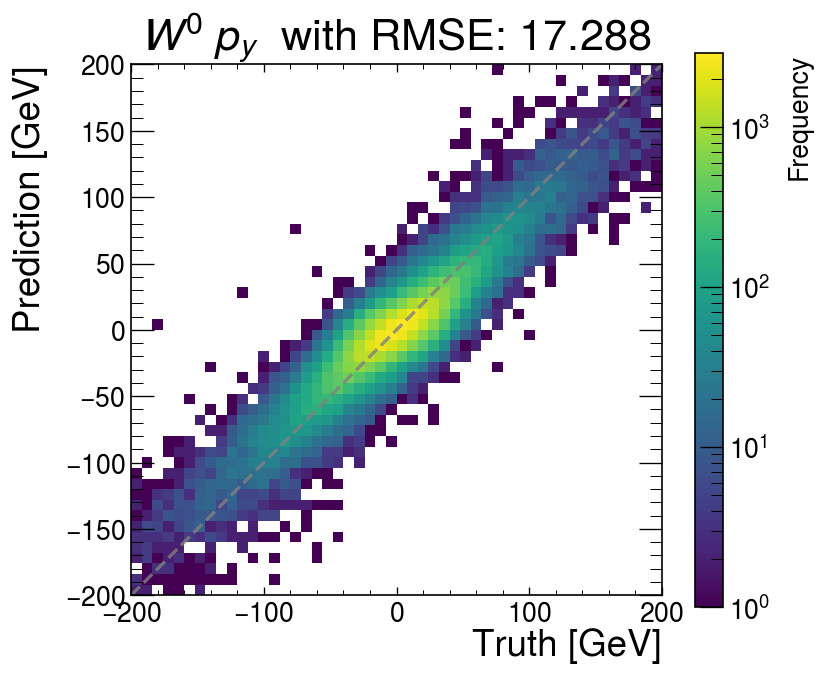

In [ ]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{y}$",
    title="$W^{0}$ $p_{y}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"$W^{0}$ $p_{y}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50 
)

Truth mean: 0.031, std: 27.968, min: -417.838, max: 580.447


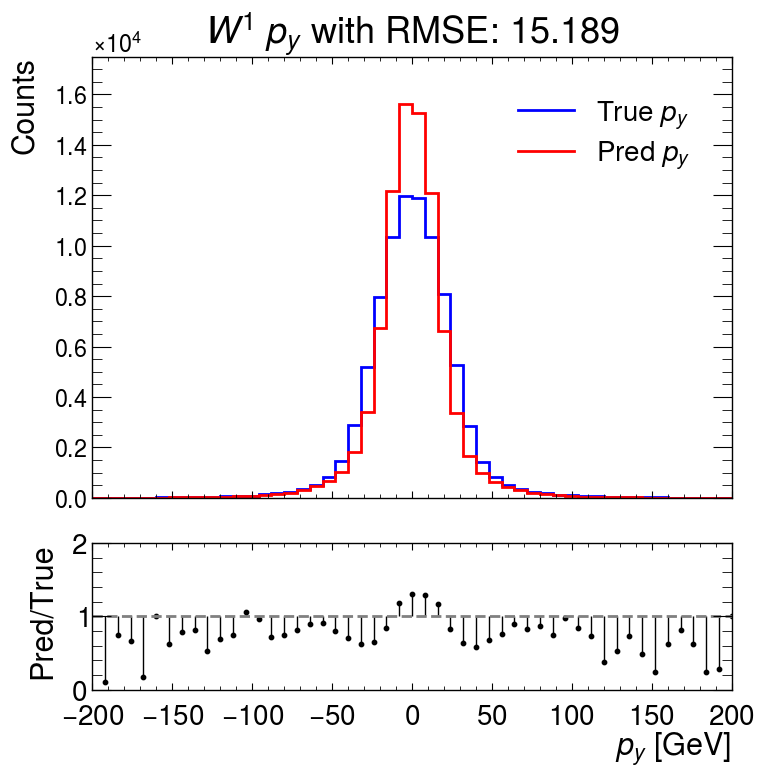

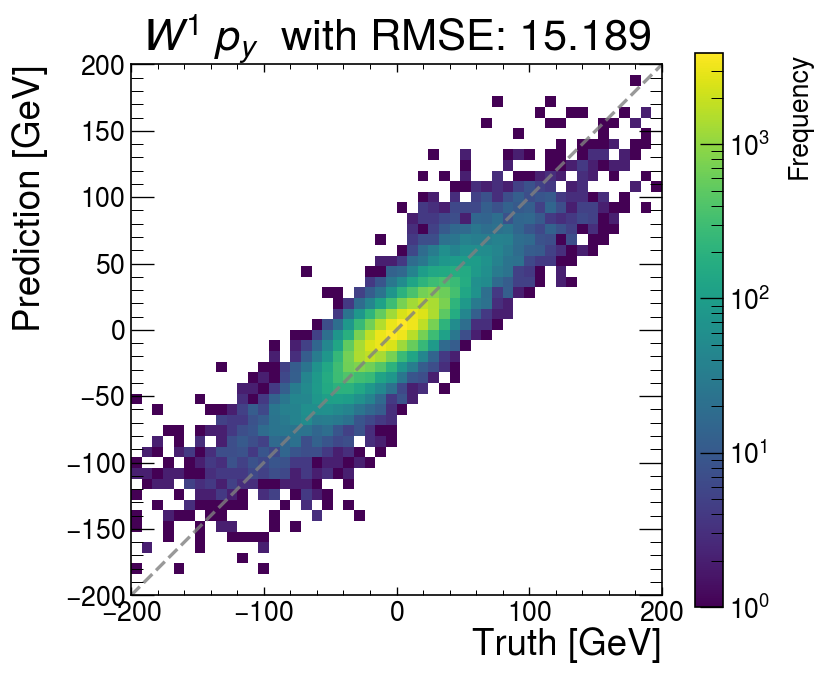

In [ ]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,5]):.3f}, std: {np.std(sig_truth_inv[:,5]):.3f}, min: {np.min(sig_truth_inv[:,5]):.3f}, max: {np.max(sig_truth_inv[:,5]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 5], sig_pred_inv[:, 5]],
    label=r"$p_{y}$",
    title="$W^{1}$ $p_{y}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,5], sig_pred_inv[:,5], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 5],
    sig_pred_inv[:, 5],
    r"$W^{1}$ $p_{y}$ " + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,5], sig_pred_inv[:,5], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50
)

Truth mean: 0.308, std: 170.752, min: -1446.473, max: 1754.351


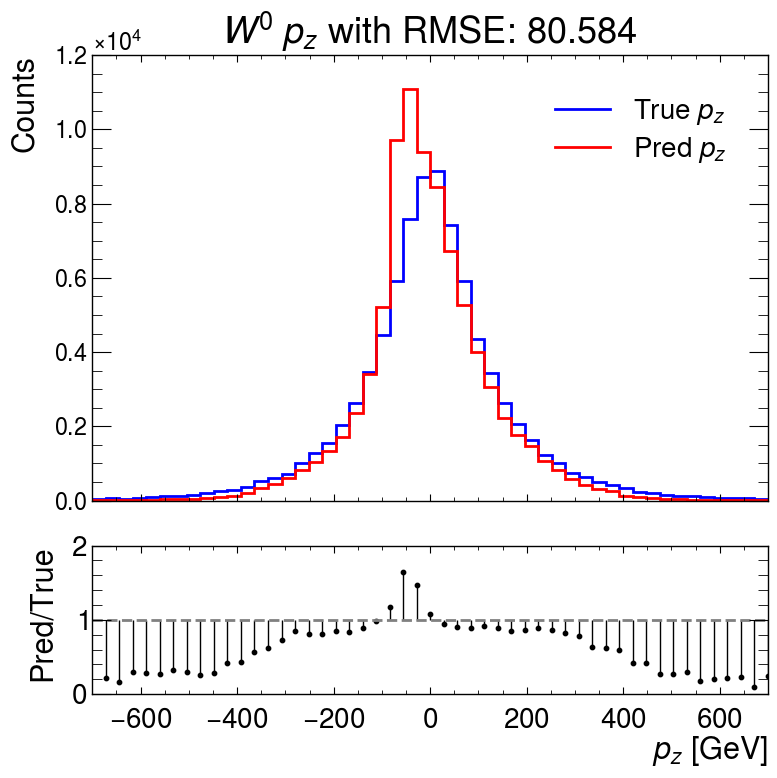

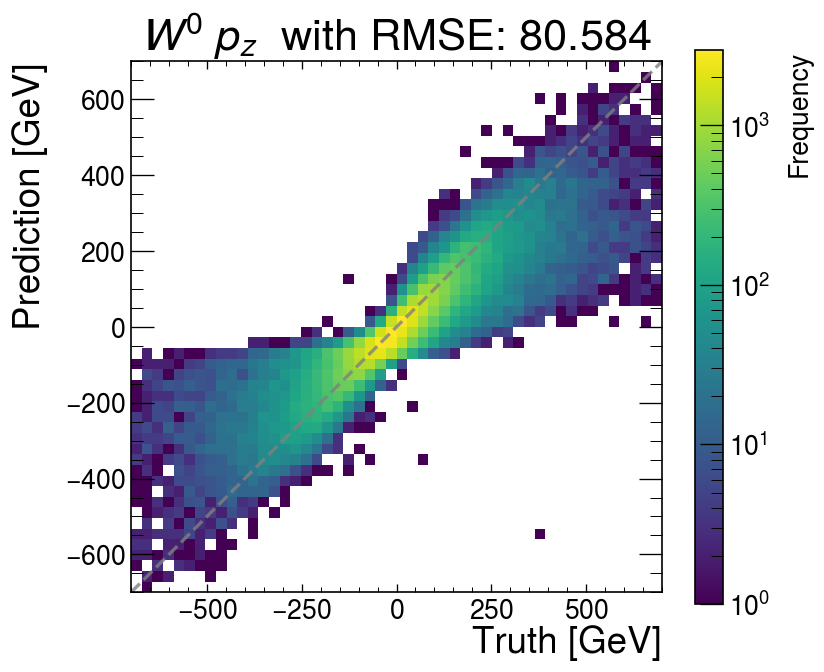

In [ ]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-700, 700]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{z}$",
    title="$W^{0}$ $p_{z}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"$W^{0}$ $p_{z}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50
)

Truth mean: -0.337, std: 110.947, min: -1170.774, max: 1427.069


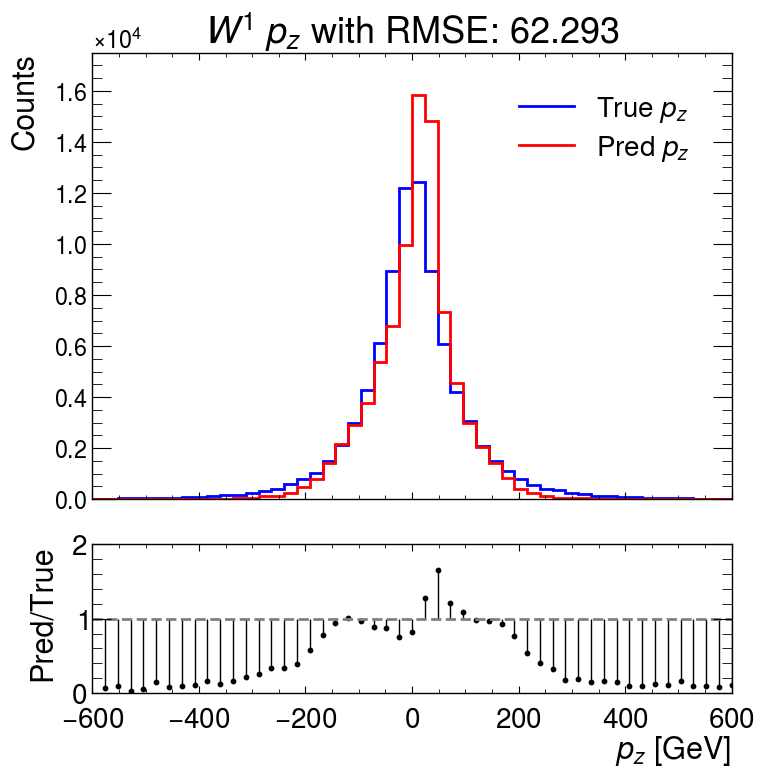

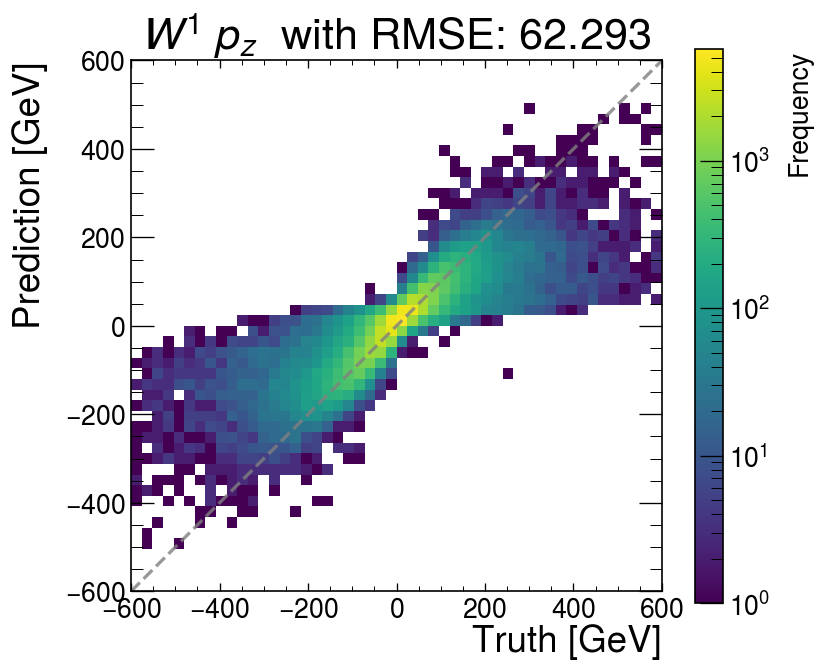

In [ ]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,6]):.3f}, std: {np.std(sig_truth_inv[:,6]):.3f}, min: {np.min(sig_truth_inv[:,6]):.3f}, max: {np.max(sig_truth_inv[:,6]):.3f}"
)

set_range = [-600, 600]

plot.hist(
    data=[sig_truth_inv[:, 6], sig_pred_inv[:, 6]],
    label=r"$p_{z}$",
    title="$W^{1}$ $p_{z}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 6],
    sig_pred_inv[:, 6],
    r"$W^{1}$ $p_{z}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50
)

Truth mean: 158.446, std: 111.648, min: 21.707, max: 1791.292


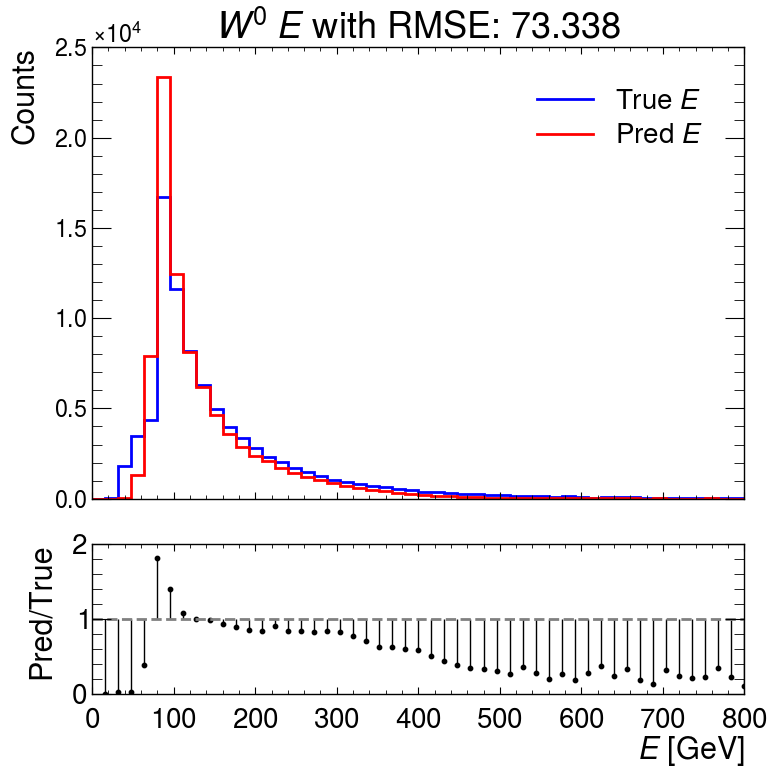

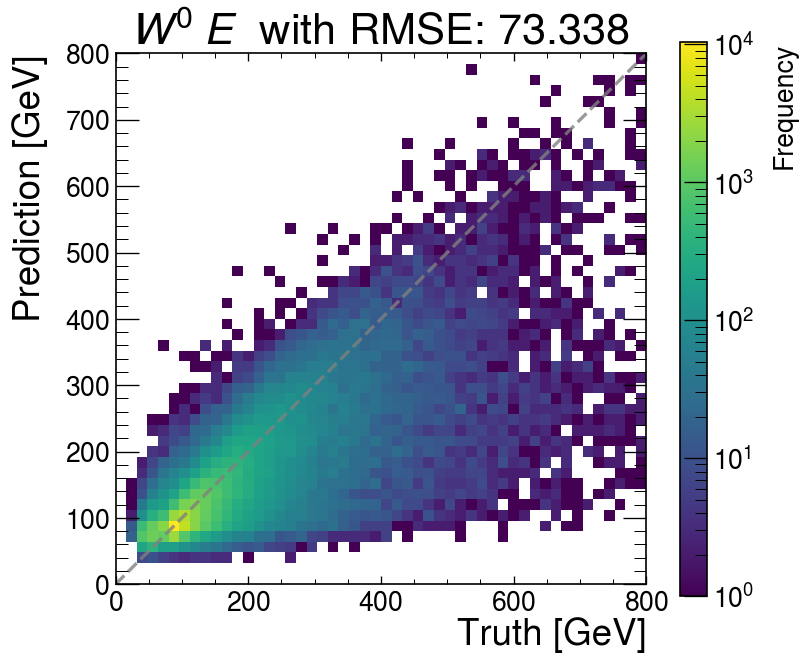

In [ ]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 800]

plot.hist(
    data=[sig_truth_inv[:, 3], sig_pred_inv[:, 3]],
    label=r"$E$",
    title="$W^{0}$ $E$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 3],
    sig_pred_inv[:, 3],
    r"$W^{0}$ $E$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50
)

Truth mean: 98.991, std: 77.608, min: 17.001, max: 1443.825


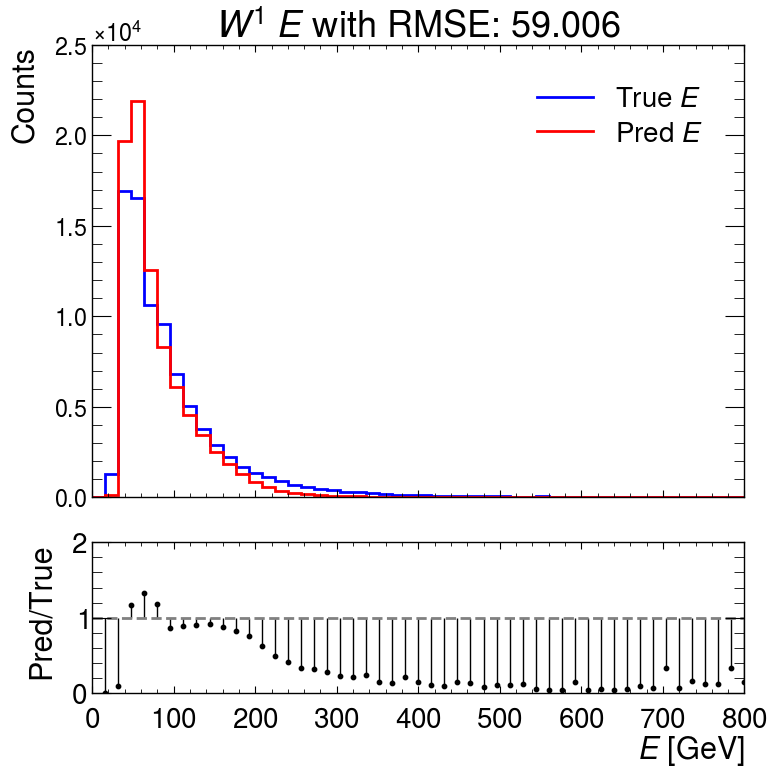

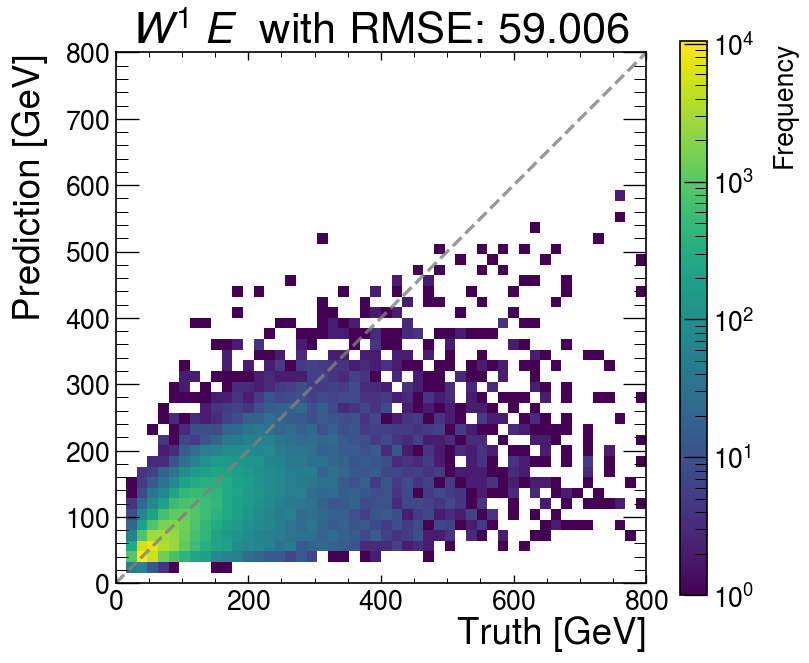

In [ ]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,7]):.3f}, std: {np.std(sig_truth_inv[:,7]):.3f}, min: {np.min(sig_truth_inv[:,7]):.3f}, max: {np.max(sig_truth_inv[:,7]):.3f}"
)

set_range = [0, 800]

plot.hist(
    data=[sig_truth_inv[:, 7], sig_pred_inv[:, 7]],
    label=r"$E$",
    title="$W^{1}$ $E$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 7],
    sig_pred_inv[:, 7],
    r"$W^{1}$ $E$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins=50,
)

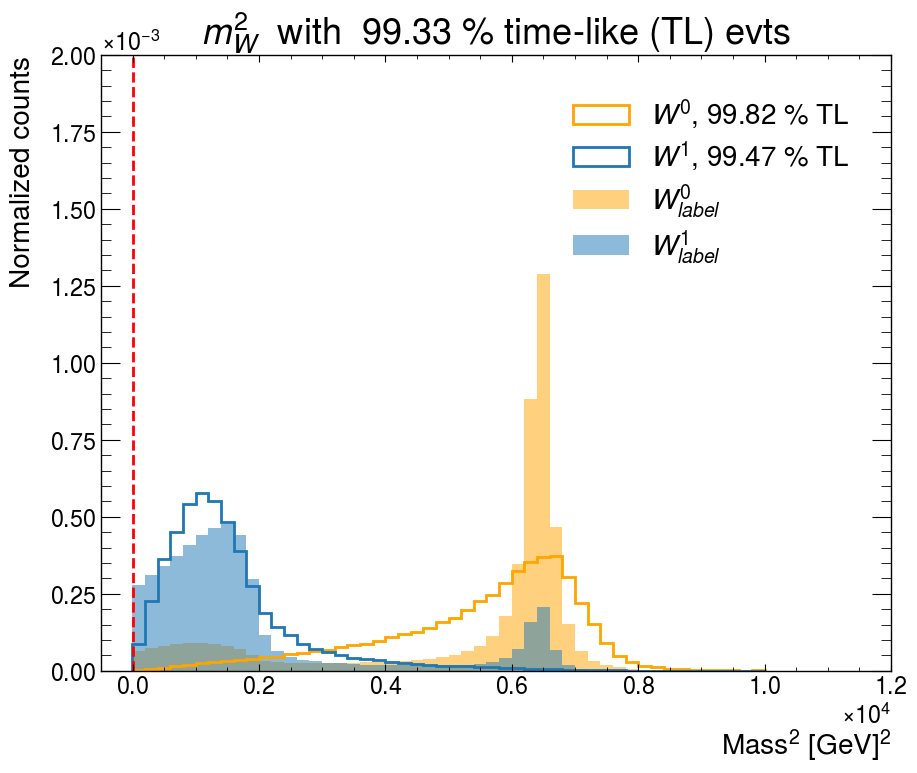

In [ ]:
lead_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
lead_time_mask = (lead_time_like > 0) * 1
sublead_time_like = np.square(sig_pred_inv[:, 7]) - np.sum(
    np.square(sig_pred_inv[:, 4:7]), axis=1
)
sublead_time_mask = (sublead_time_like > 0) * 1

bin_edges = np.linspace(-5, 1.0e4, 51)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    lead_time_like,
    bins=bin_edges,
    fill=False,
    color="orange",
    histtype="step",
    label=r"$W^{0}$, "
    + f"{100 * np.sum(lead_time_mask) / len(lead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    sublead_time_like,
    bins=bin_edges,
    fill=False,
    color="tab:blue",
    histtype="step",
    label=r"$W^{1}$, "
    + f"{100 * np.sum(sublead_time_mask) / len(sublead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    np.square(w_lead.m),
    bins=bin_edges,
    color="orange",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{0}$",
    density=True,
    # weights=mc_weight,
)
plt.hist(
    np.square(w_sublead.m),
    bins=bin_edges,
    color="tab:blue",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{1}$",
    density=True,
    # weights=mc_weight,
)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.xlim(-5e2, 1.2e4)
plt.ylim(0, 2e-3)
plt.xlabel(r"Mass$^{2}$ [GeV]$^{2}$", labelpad=20)
plt.ylabel("Normalized counts")
plt.title(
    r"$m^{2}_{W}$ "
    + f" with {100 * np.sum(lead_time_mask * sublead_time_mask) / len(lead_time_mask): .2f} % time-like (TL) evts",
    fontsize=26,
    )
plt.legend(loc="upper right", prop={'size': 20})  # Adjust the size value as needed
plt.show()

Truth mean: 3615.291, std: 2594.373, min: 4.010, max: 11077.988


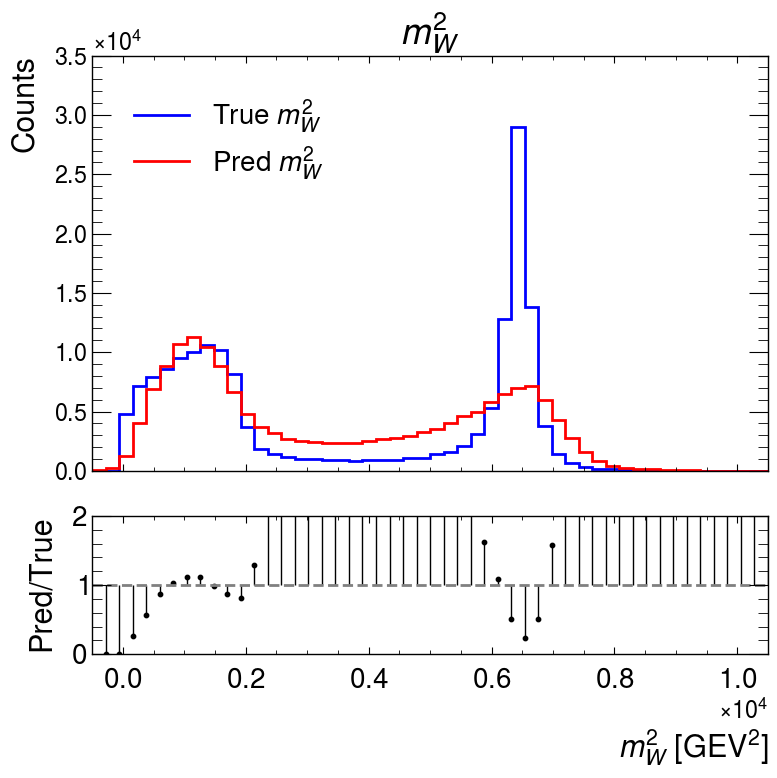

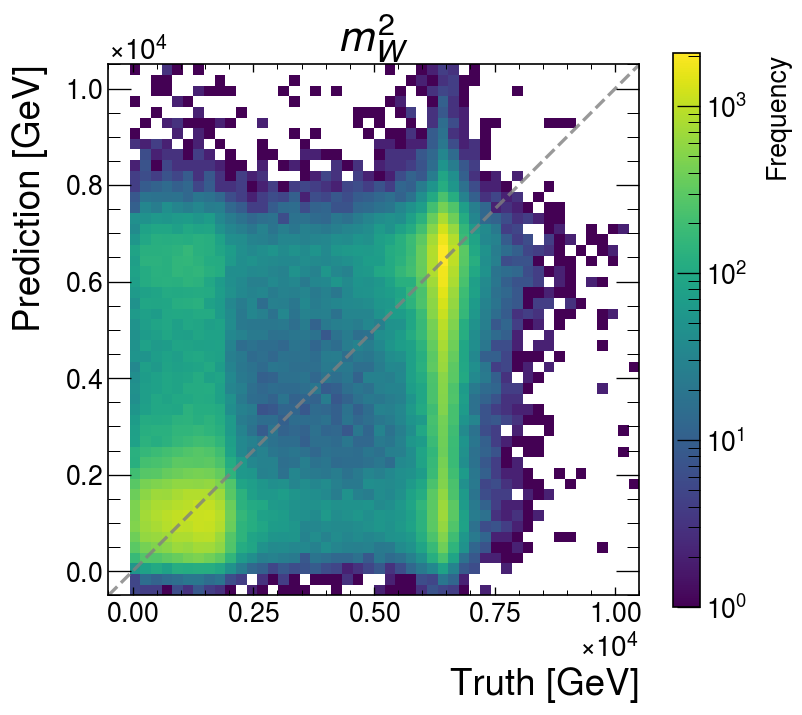

In [ ]:
# TODO: 2d mass squared
pred_m2 = np.concatenate([lead_time_like, sublead_time_like], axis=-1)
truth_m2 = np.concatenate(
    [np.square(w_lead.m)[test_indices], np.square(w_sublead.m)[test_indices]], axis=-1
)

print(
    f"Truth mean: {np.mean(truth_m2):.3f}, std: {np.std(truth_m2):.3f}, min: {np.min(truth_m2):.3f}, max: {np.max(truth_m2):.3f}"
)

set_range = [-500, 10_500]

plot.hist(
    data=[truth_m2, pred_m2],
    label=r"$m_{W}^{2}$",
    title="$m_{W}^{2}$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(truth_m2, pred_m2)):.3f}",
    range=set_range,
    unit=r"[GEV$^{2}$]",
    xpad=24,
    # weights=np.append(mc_weight[test_indices], mc_weight[test_indices]),
)

plot.plot_2d_histogram(
    truth_m2,
    pred_m2,
    r"$m_{W}^{2}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(truth_m2, pred_m2)):.3f}",
    range=set_range,
    xpad=24,
    bins=50,
    # weights=np.append(mc_weight[test_indices], mc_weight[test_indices]),
)

In [ ]:

# TODO: CGLMP

def Bij(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """
        This is a function to calculate Bij (CGLMP values).
        :param z_xp: Angle (xi) between positive lepton and x-axis.
        :param z_xn: Angle (xi) between negative lepton and x-axis.
        :param z_yp: Angle (xi) between positive lepton and y-axis.
        :param z_xn: Angle (xi) between negative lepton and y-axis.
        """
        # count expectation value, use (27) in Alan's paper
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = (
            25
            * (np.square(z_xp) - np.square(z_yp))
            * (np.square(z_xn) - np.square(z_yn))
        )
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        tr = tr_a + tr_b + tr_c

        return tr

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
    )
    
def result_generator(particles):
    with multiprocessing.Pool(WORKERS) as pool:
        # Retrieve the output from the pool
        results = list(pool.map(Bij, particles))
    
    # Unpack the results
    bij, xi_p, xi_n = zip(*results)
    
    bij = np.vstack(bij)  # Flatten the nested array
    xi_p = np.vstack(xi_p)
    xi_n = np.vstack(xi_n)
    mask = np.any(np.isnan(bij), axis=1)
    return (
        bij[~mask, :],
        xi_p[~mask, :],
        xi_n[~mask, :],
    )

In [ ]:
# reco
particles = np.concatenate(
    [
        sig_pred_inv[:, 0:4],
        lead_lep_p4[test_indices],
        sig_pred_inv[:, 4:8],
        sublead_lep_p4[test_indices],
    ],
    axis=1,
)
bij = result_generator(particles)[0][0:80_000,:]
xi_p = result_generator(particles)[1][0:80_000,:]
xi_n = result_generator(particles)[2][0:80_000,:]

# truth
particles = np.concatenate(
    [
        sig_truth_inv[:, 0:4],
        truth_lead_lep_p4[test_indices],
        sig_truth_inv[:, 4:8],
        truth_sublead_lep_p4[test_indices],
    ],
    axis=1,
)
truth_bij = result_generator(particles)[0][0:80_000,:]
truth_xi_p = result_generator(particles)[1][0:80_000,:]
truth_xi_n = result_generator(particles)[2][0:80_000,:]

Truth mean    : 2.468, std: 12.019, min: -25.100, max: 29.607
Predicted mean: 4.285, std: 11.481, min: -25.104, max: 29.618


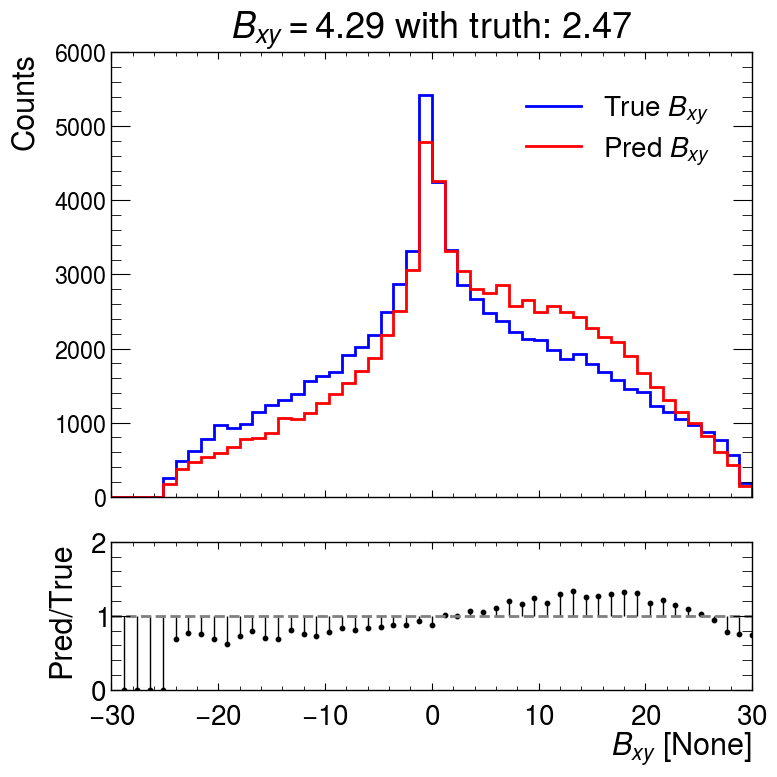

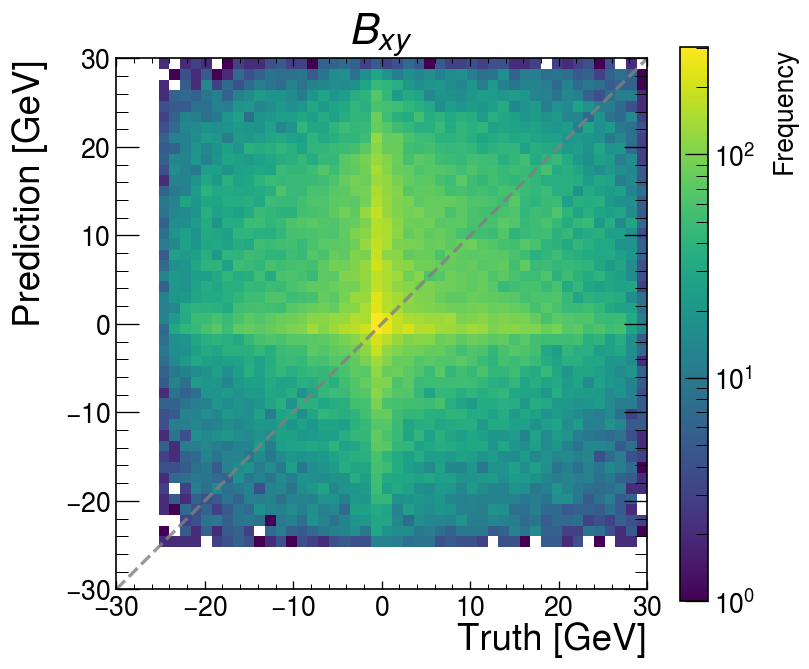

In [ ]:

print(
    f"Truth mean    : {np.mean(truth_bij[:,0]):.3f}, std: {np.std(truth_bij[:,0]):.3f}, min: {np.min(truth_bij[:,0]):.3f}, max: {np.max(truth_bij[:,0]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,0]):.3f}, std: {np.std(bij[:,0]):.3f}, min: {np.min(bij[:,0]):.3f}, max: {np.max(bij[:,0]):.3f}"
)

set_range = [-30, 30]

plot.hist(
    data=[truth_bij[:,0], bij[:,0]],
    label=r"$B_{xy}$",
    title=rf"$B_{{xy}}={np.mean(bij[:,0]):.2f}$"
    + f" with truth: {np.mean(truth_bij[:,0]):.2f}",
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_bij[:,0],
    bij[:,0],
    r"$B_{xy}$",
    range=set_range,
    weights=None,
    bins=50
)

Truth mean    : 2.060, std: 8.727, min: -25.095, max: 29.572
Predicted mean: 1.074, std: 8.168, min: -25.094, max: 29.564


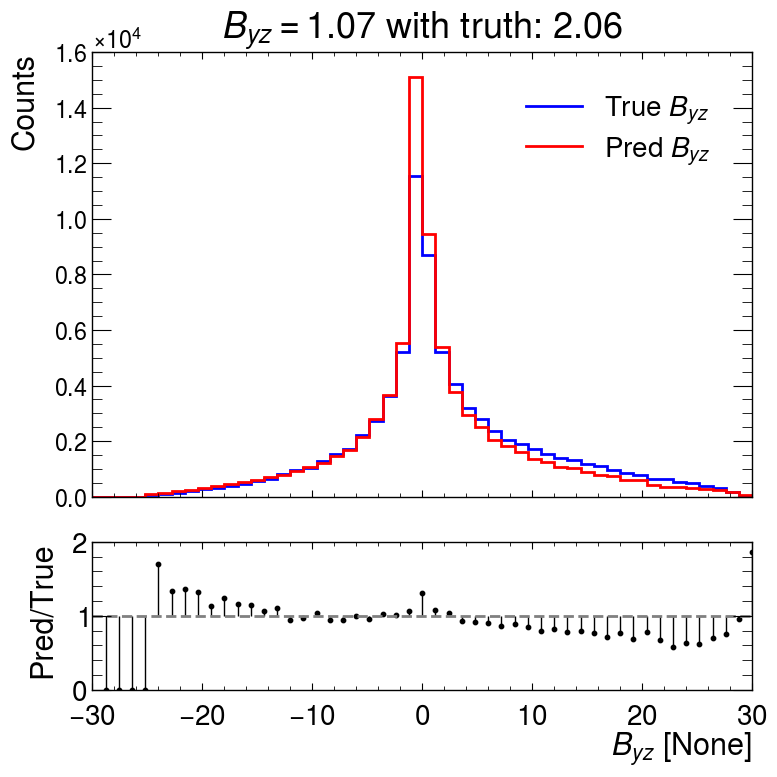

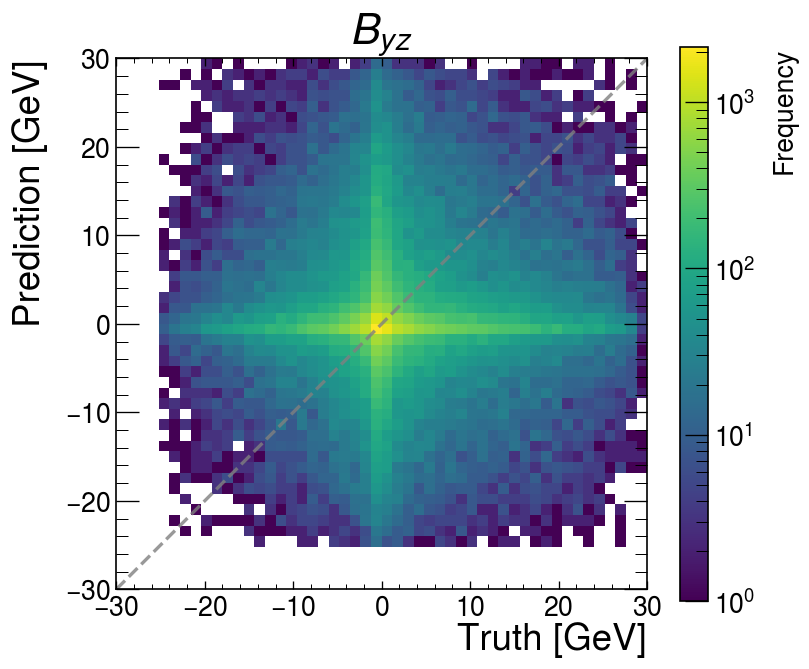

In [ ]:

print(
    f"Truth mean    : {np.mean(truth_bij[:,1]):.3f}, std: {np.std(truth_bij[:,1]):.3f}, min: {np.min(truth_bij[:,1]):.3f}, max: {np.max(truth_bij[:,1]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,1]):.3f}, std: {np.std(bij[:,1]):.3f}, min: {np.min(bij[:,1]):.3f}, max: {np.max(bij[:,1]):.3f}"
)

set_range = [-30, 30]

plot.hist(
    data=[truth_bij[:,1], bij[:,1]],
    label=r"$B_{yz}$",
    title=rf"$B_{{yz}}={np.mean(bij[:,1]):.2f}$"
    + f" with truth: {np.mean(truth_bij[:,1]):.2f}",
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_bij[:,1],
    bij[:,1],
    r"$B_{yz}$",
    range=set_range,
    weights=None,
    bins=50
)

Truth mean    : 3.228, std: 10.739, min: -25.073, max: 29.599
Predicted mean: 1.508, std: 11.538, min: -25.078, max: 29.510


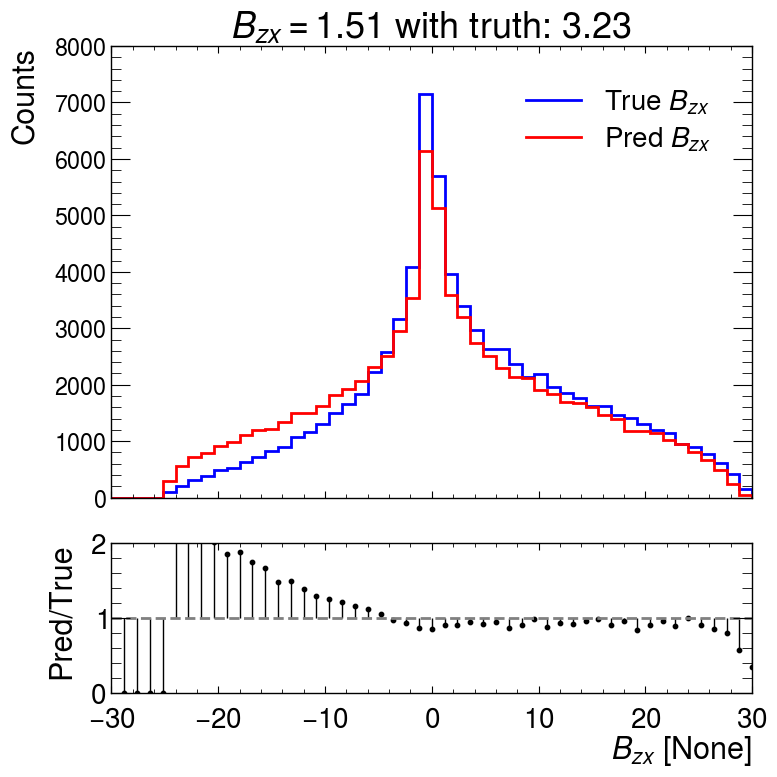

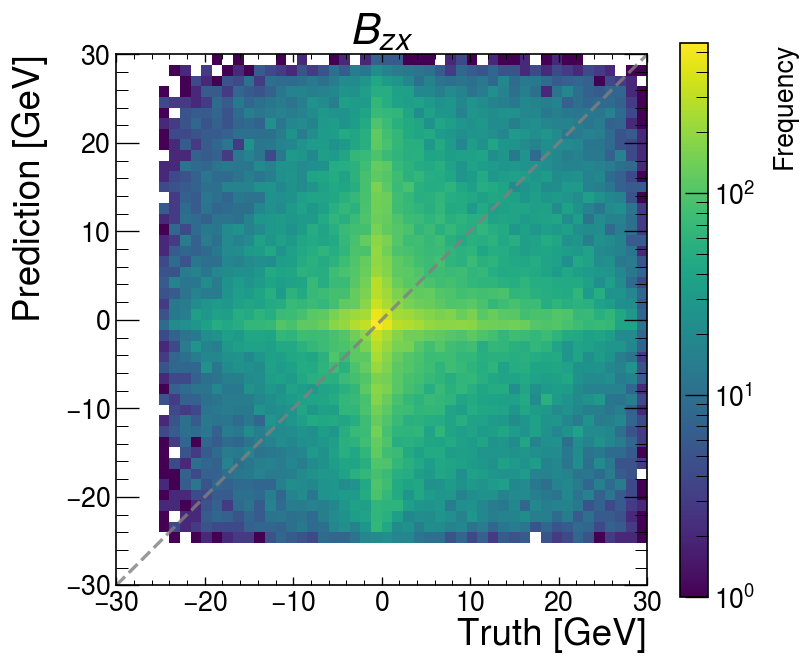

In [ ]:

print(
    f"Truth mean    : {np.mean(truth_bij[:,2]):.3f}, std: {np.std(truth_bij[:,2]):.3f}, min: {np.min(truth_bij[:,2]):.3f}, max: {np.max(truth_bij[:,2]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,2]):.3f}, std: {np.std(bij[:,2]):.3f}, min: {np.min(bij[:,2]):.3f}, max: {np.max(bij[:,2]):.3f}"
)

set_range = [-30, 30]

plot.hist(
    data=[truth_bij[:,2], bij[:,2]],
    label=r"$B_{zx}$",
    title=rf"$B_{{zx}}={np.mean(bij[:,2]):.2f}$"
    + f" with truth: {np.mean(truth_bij[:,2]):.2f}",
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_bij[:,2],
    bij[:,2],
    r"$B_{zx}$",
    range=set_range,
    weights=None,
    bins=50
)

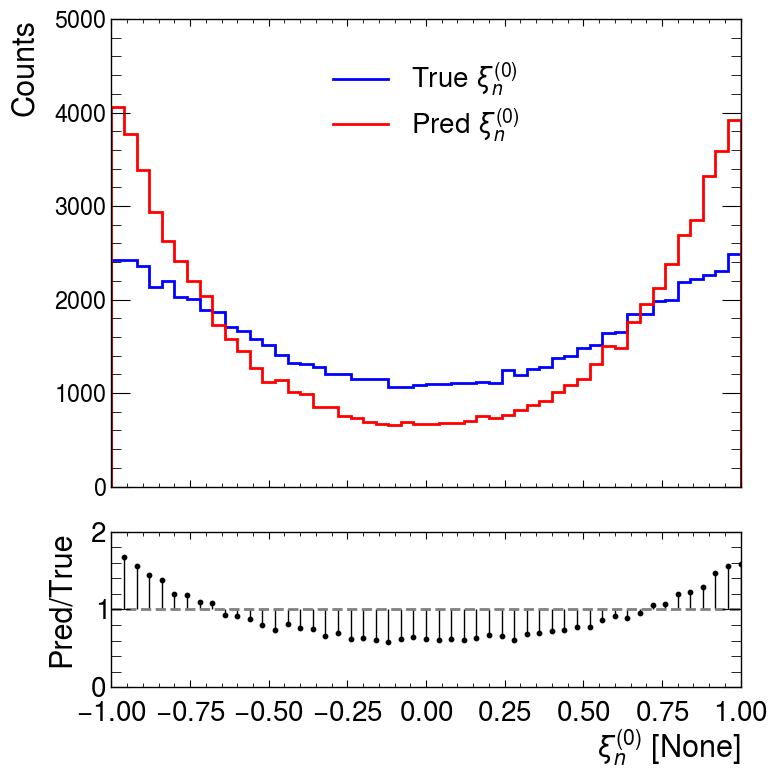

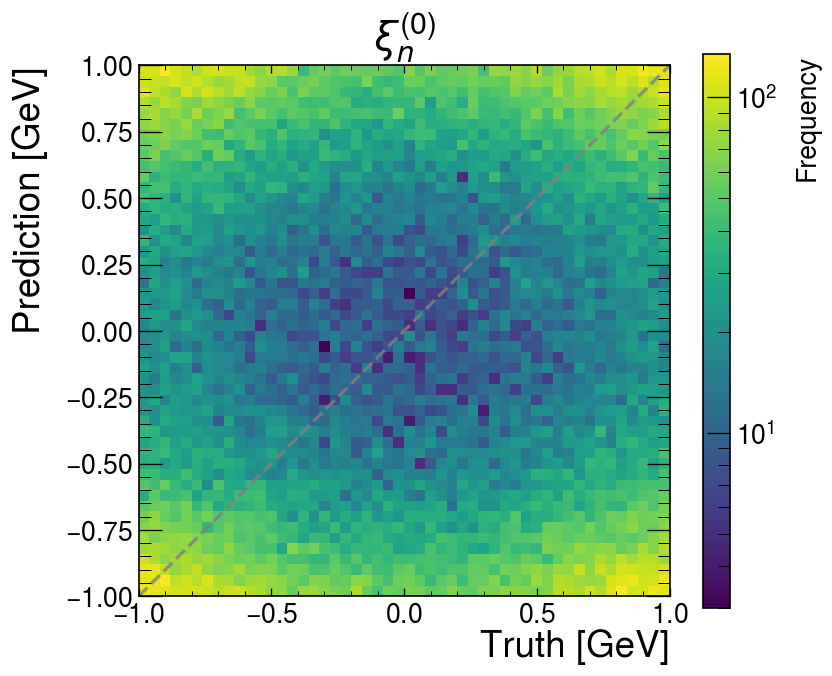

In [ ]:
set_range = [-1, 1]

plot.hist(
    data=[truth_xi_p[:,0], xi_p[:,0]],
    label=r"$\xi^{(0)}_{n}$",
    title=None,
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_xi_p[:,0],
    xi_p[:,0],
    r"$\xi^{(0)}_{n}$",
    range=set_range,
    weights=None,
    bins=50
)

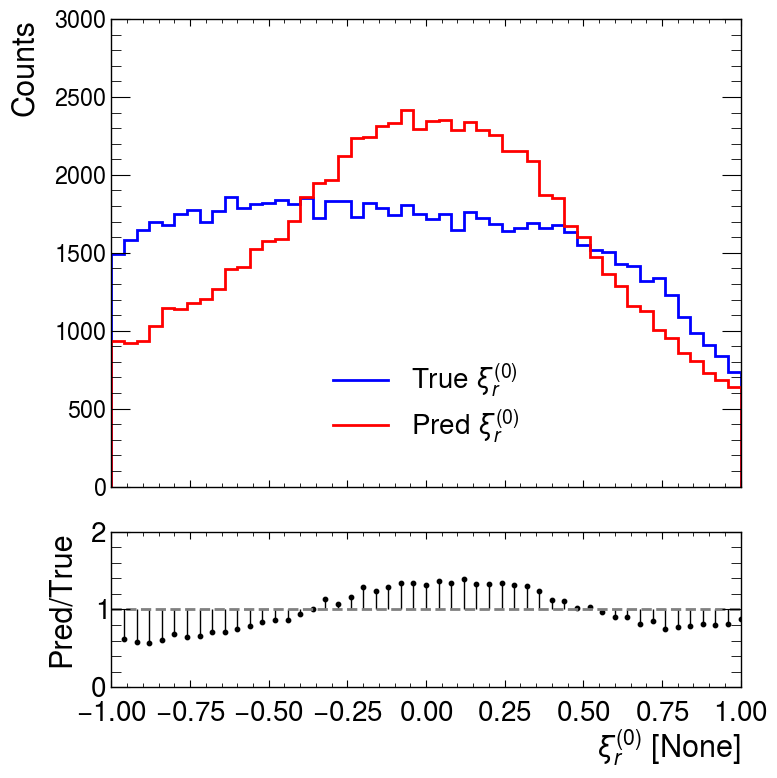

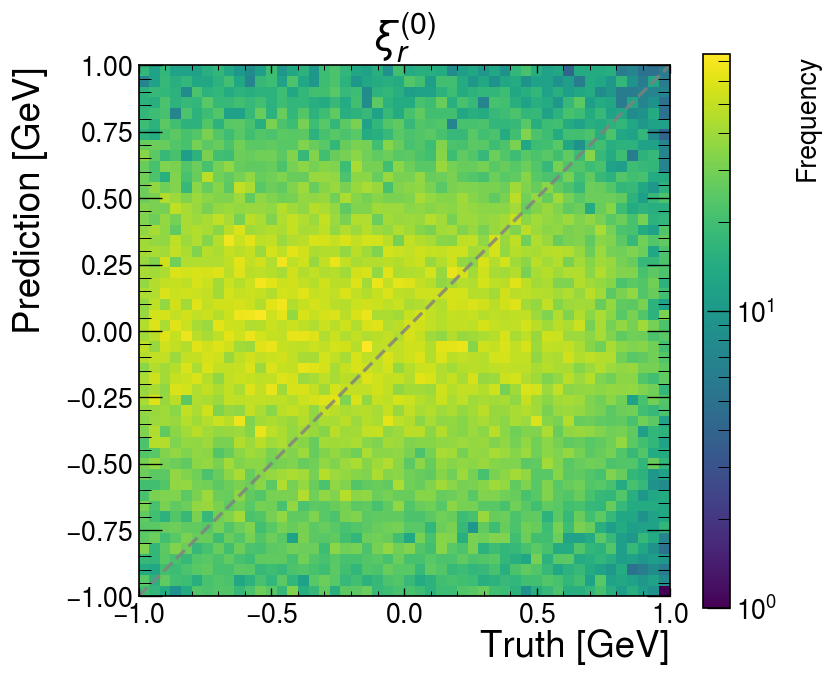

In [ ]:
set_range = [-1, 1]

plot.hist(
    data=[truth_xi_p[:,1], xi_p[:,1]],
    label=r"$\xi^{(0)}_{r}$",
    title=None,
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_xi_p[:,1],
    xi_p[:,1],
    r"$\xi^{(0)}_{r}$",
    range=set_range,
    weights=None,
    bins=50
)

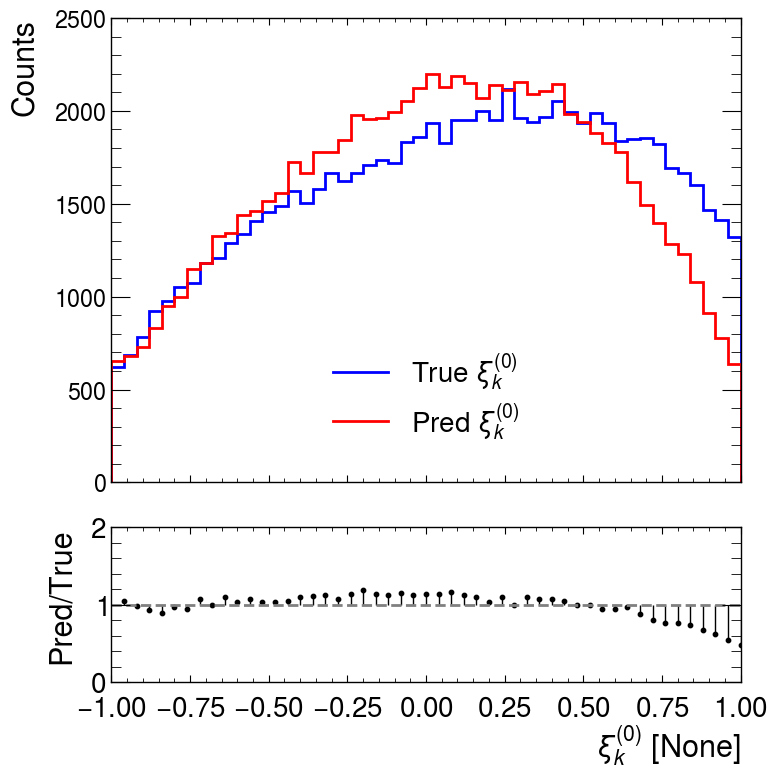

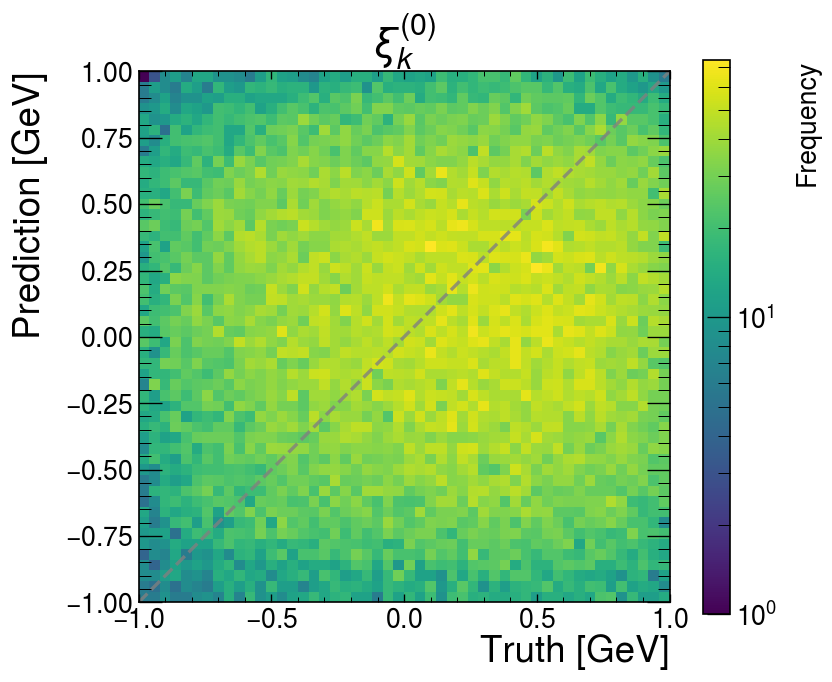

In [ ]:
set_range = [-1, 1]

plot.hist(
    data=[truth_xi_p[:,2], xi_p[:,2]],
    label=r"$\xi^{(0)}_{k}$",
    title=None,
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_xi_p[:,2],
    xi_p[:,2],
    r"$\xi^{(0)}_{k}$",
    range=set_range,
    weights=None,
    bins=50
)

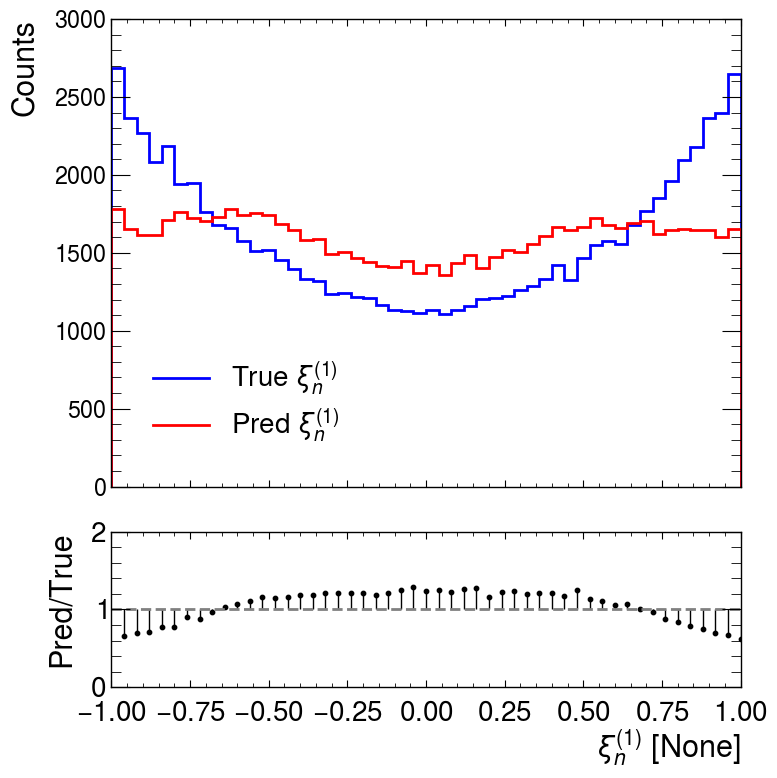

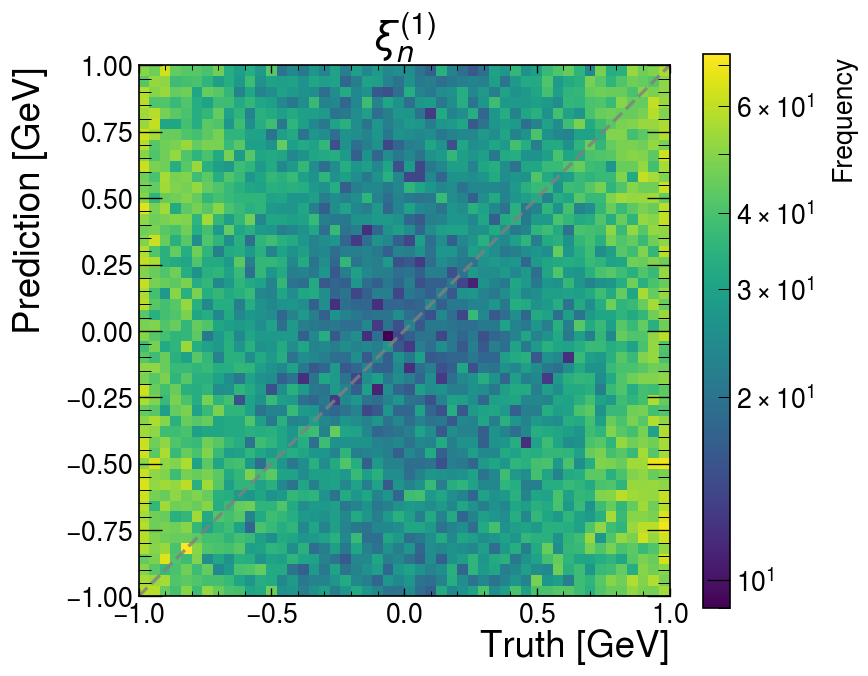

In [ ]:
set_range = [-1, 1]

plot.hist(
    data=[truth_xi_n[:,0], xi_n[:,0]],
	label=r"$\xi^{(1)}_{n}$",
	title=None,
	range=set_range,
	unit="[None]",
	weights=None,
)

plot.plot_2d_histogram(
	truth_xi_n[:,0],
	xi_n[:,0],
	r"$\xi^{(1)}_{n}$",
	range=set_range,
	weights=None,
	bins=50
)

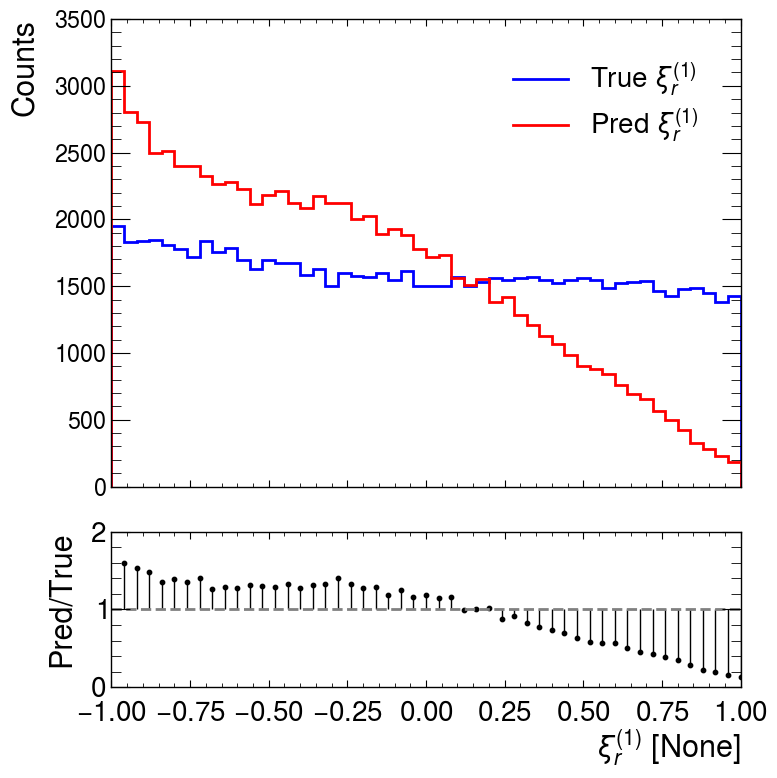

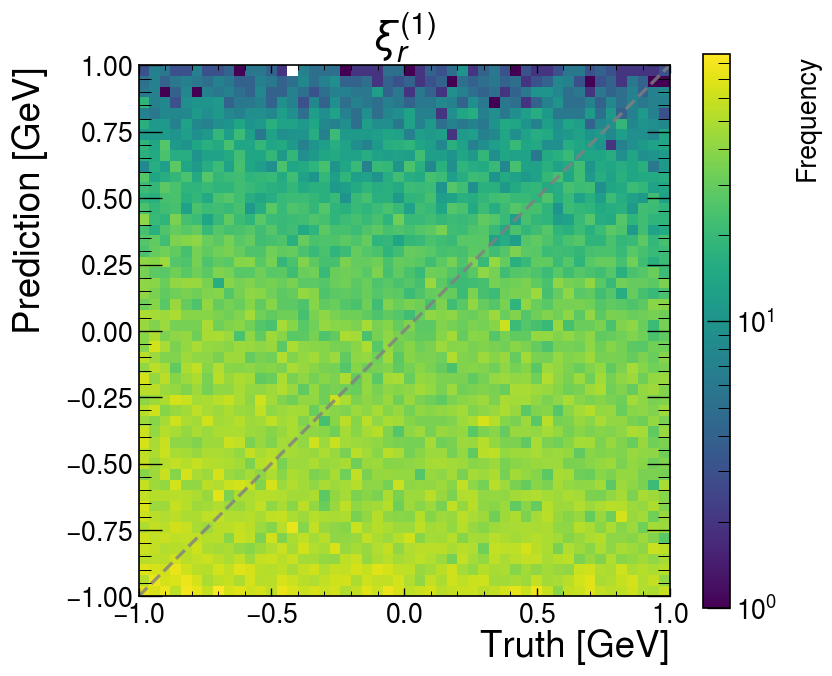

In [ ]:
set_range = [-1, 1]

plot.hist(	
	data=[truth_xi_n[:,1], xi_n[:,1]],
	label=r"$\xi^{(1)}_{r}$",
	title=None,
	range=set_range,
	unit="[None]",
	weights=None,
)

plot.plot_2d_histogram(
	truth_xi_n[:,1],
	xi_n[:,1],
	r"$\xi^{(1)}_{r}$",
	range=set_range,
	weights=None,
	bins=50
)

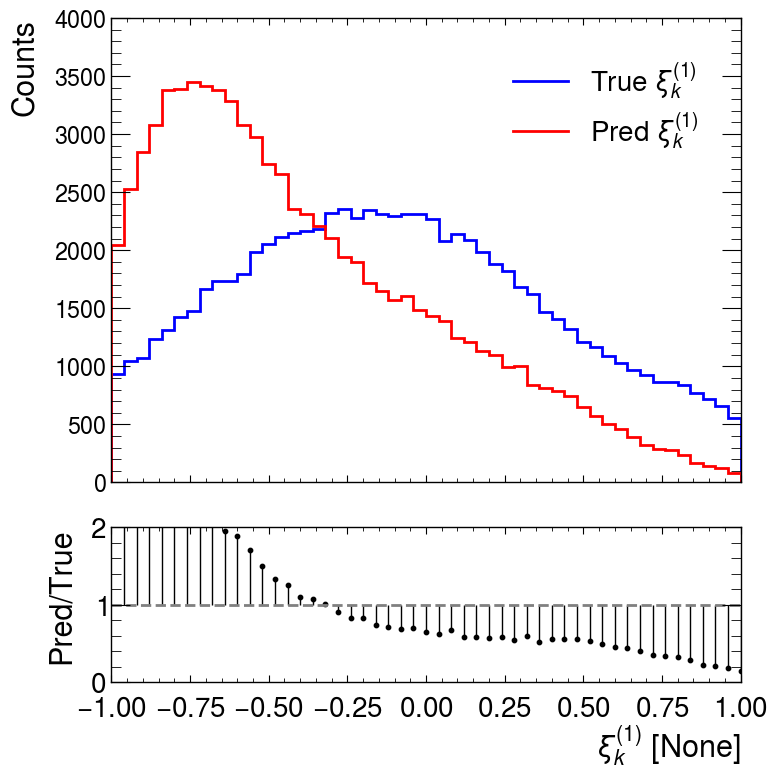

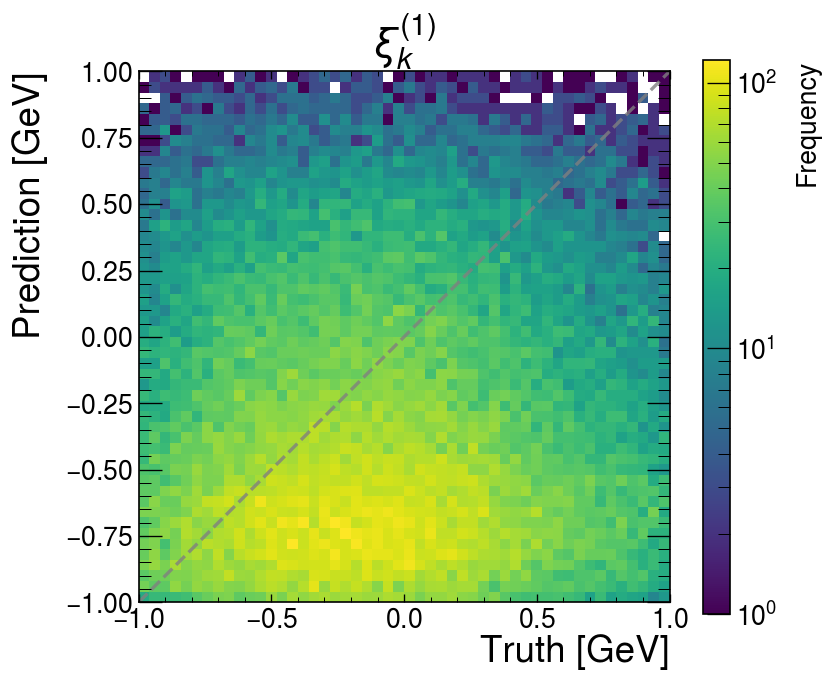

In [ ]:
set_range = [-1, 1]

plot.hist(
	data=[truth_xi_n[:,2], xi_n[:,2]],
	label=r"$\xi^{(1)}_{k}$",
	title=None,
	range=set_range,
	unit="[None]",
	weights=None,
)

plot.plot_2d_histogram(
	truth_xi_n[:,2],
	xi_n[:,2],
	r"$\xi^{(1)}_{k}$",
	range=set_range,
	weights=None,
	bins=50
)